# Merge Fors2, StarLight ,Galex and Kids


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023-06-09
- last update : 2023-06-15

This shows that Starlight spectra are not compatible with photometry

From this mergin work on spectra and photometry can start

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import copy

In [2]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [3]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info

# Read Fors2

In [4]:
input_file_h5  = '../data/FORS2spectra.hdf5'

In [5]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [6]:
df_info = ReadFors2h5FileAttributes(hf)

In [7]:
df_info.reset_index(drop=True, inplace=True) 

In [8]:
df_info

num     name        ra       dec   Rmag  redshift  \
0      2    SPEC2  13.52997 -28.44776  21.18   0.34555   
1      3    SPEC3  13.52552 -28.42080  21.45   0.68660   
2      9    SPEC9  13.50219 -28.40641  21.60   0.29266   
3     13   SPEC13  13.49261 -28.38272  23.14   0.68870   
4     19   SPEC19  13.60758 -28.43452  21.70   0.48395   
..   ...      ...       ...       ...    ...       ...   
545  734  SPEC734  13.68083 -28.23290   0.00   0.23012   
546  735  SPEC735  13.69958 -28.23161  19.28   0.36169   
547  736  SPEC736  13.66431 -28.22849  21.64   0.55777   
548  737  SPEC737  13.62722 -28.22692  21.40   0.52001   
549  738  SPEC738  13.64370 -28.22527  19.73   0.56044   

                                                 lines    RT      RV  eRV  Nsp  
0    b'K,H,G,H{beta}                               ...  12.3  103665   40    1  
1    b'[OII],H9,K,H,H{beta},[OIII],H8              ...  11.6  210642   48    4  
2    b'H9,H8,K,H                                   ...  13.1   87798   58    1  
3    b'[OII],H{epsilon},H{delta},H{beta}           ...   0.0  206610    0    1  
4    b'H10,H9,H8,K,H,H{delta}                      ...   7.1  145185  104    1  
..                                                 ...   ...     ...  ...  ...  
545  b'[OII],H9,K,H,H{alpha},NII                   ...   7.2   69036   71    1  
546  b'K,H,G,H{beta}                               ...   8.2  108507  107    1  
547  b'[OII],H9,H{beta},[OIII]                     ...  10.5  167331   31    1  
548  b'[OII],K,H                                   ...  10.2  156003   53    1  
549  b'K,H,4000{AA}-break,G                        ...   7.1  168132  126    1  

[550 rows x 11 columns]

### Get Spectra

In [9]:
df_info_num = df_info["num"].values
key_tags = [ f"SPEC{num}" for num in df_info_num ]

In [10]:
all_df = []   
idx=0
for key in key_tags :
    group = hf.get(key)
    df = pd.DataFrame()
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
    all_df.append(df)
    idx+=1

# Get StarLight Spectra

In [11]:
input_SLfile_h5  = '../data/SLspectra.hdf5'

In [12]:
with h5py.File(input_SLfile_h5, 'r') as hf:
    data_in = hf['flambda'][:]
    wl_in = hf['wl'][:]
    #target = hf['quantile'][:]

    # other data
    redshift_sl = hf['redshift'][:]
    Rmag_sl = hf['Rmag'][:]
    RT_sl = hf['RT'][:]
    RV_sl = hf['RV'][:]
    ra_sl = hf['ra'][:]
    dec_sl = hf['dec'][:]
    #fracinfbalmer = hf['fracinfbalmer'][:]
    num_sl = hf['num'][:]

In [13]:
spectra_sl = data_in
wavelengths_sl = wl_in

In [14]:
spectra_sl.shape 

(550, 12000)

In [15]:
wavelengths_sl.shape

(12000,)

In [16]:
NSL = spectra_sl.shape[0]
NSLWL = spectra_sl.shape[1]

## Renormalize and redshift

In [17]:
spectra_sl_z = spectra_sl/(1+redshift_sl[:,np.newaxis])
wavelengths_sl_z = wavelengths_sl[np.newaxis,:]*(1+redshift_sl[:,np.newaxis])

In [18]:
wavelengths_sl_z.shape

(550, 12000)

In [19]:
spectra_sl_z.shape

(550, 12000)

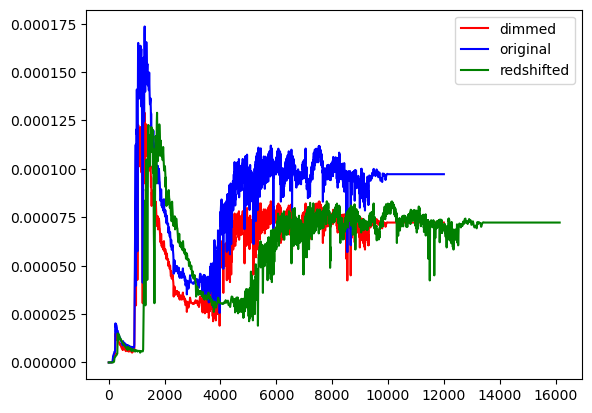

In [20]:
plt.plot(wavelengths_sl,spectra_sl_z[0,:],"r",label="dimmed")
plt.plot(wavelengths_sl,spectra_sl[0,:],"b",label="original")
plt.plot(wavelengths_sl_z[0,:],spectra_sl_z[0,:],"g",label="redshifted")
plt.legend()

## Renormalize

In [21]:
lambda_red = 6231
lambda_width = 50
lambda_sel_min = lambda_red-lambda_width /2.
lambda_sel_max = lambda_red+lambda_width /2.

In [22]:
all_flarr_norm = []
spectra_sl_z_norm = copy.deepcopy(spectra_sl_z)  

for idx in range(NSL):
    wl = wavelengths_sl_z[idx,:]
    fl = spectra_sl_z[idx,:] 
    idx_wl_sel = np.where(np.logical_and(wl>= lambda_sel_min,wl<= lambda_sel_max))[0]
    flarr_norm = fl[idx_wl_sel]
    factor = np.median(flarr_norm)
    spectra_sl_z_norm[idx,:] = spectra_sl_z[idx,:]/factor*np.power(10,-0.4*Rmag_sl[idx])
    all_flarr_norm.append(np.median(flarr_norm))

In [23]:
Rmag_sl[0]

21.18

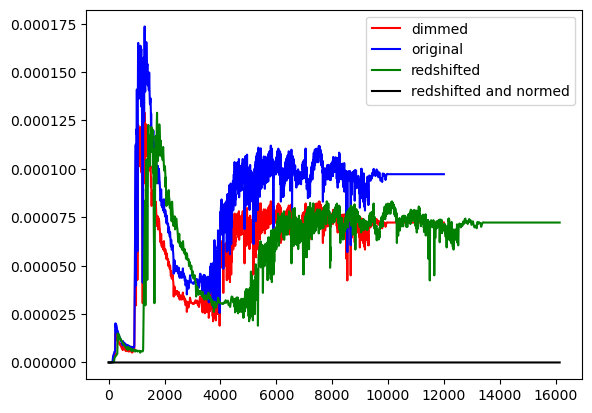

In [24]:
plt.plot(wavelengths_sl,spectra_sl_z[0,:],"r",label="dimmed")
plt.plot(wavelengths_sl,spectra_sl[0,:],"b",label="original")
plt.plot(wavelengths_sl_z[0,:],spectra_sl_z[0,:],"g",label="redshifted")
plt.plot(wavelengths_sl_z[0,:],spectra_sl_z_norm[0,:],"k",label="redshifted and normed")
plt.legend()

# Get merged catalogs

- Be sure to use MAST results for Galex

In [25]:
catalog_galex_filename = "../data/results_crossmathcatalogs/info_fors2GALEX_frommast_crossmatch.csv"
catalog_kids_filename = "../data/results_crossmathcatalogs/info_fors2Kidscrossmatch.csv"

In [26]:
df_info_galex = pd.read_csv(catalog_galex_filename,index_col=0)

In [27]:
df_info_galex.rename(columns={"angularsep":"asep_galex"},inplace=True)

In [28]:
df_info_galex

num        ra       dec   Rmag  redshift   ra_galex  dec_galex  \
0      2  13.52997 -28.44776  21.18   0.34555  13.531423 -28.456012   
1      3  13.52552 -28.42080  21.45   0.68660  13.524429 -28.415100   
2      9  13.50219 -28.40641  21.60   0.29266  13.493582 -28.404687   
3     13  13.49261 -28.38272  23.14   0.68870  13.488292 -28.374033   
4     19  13.60758 -28.43452  21.70   0.48395  13.602319 -28.443209   
..   ...       ...       ...    ...       ...        ...        ...   
545  734  13.68083 -28.23290   0.00   0.23012  13.672907 -28.231896   
546  735  13.69958 -28.23161  19.28   0.36169  13.687228 -28.226752   
547  736  13.66431 -28.22849  21.64   0.55777  13.672907 -28.231896   
548  737  13.62722 -28.22692  21.40   0.52001  13.628613 -28.230257   
549  738  13.64370 -28.22527  19.73   0.56044  13.628613 -28.230257   

       fuv_mag    nuv_mag  fuv_magerr  nuv_magerr   fuv_flux    nuv_flux  \
0    20.422865  21.145170    0.252426    0.255224  24.595520   12.645368   
1          NaN  22.173336         NaN    0.472773        NaN    4.905293   
2          NaN  21.510794         NaN    0.360429        NaN    9.029878   
3          NaN  22.629692         NaN    0.543497        NaN    3.221977   
4          NaN  21.152737         NaN    0.287115        NaN   12.557550   
..         ...        ...         ...         ...        ...         ...   
545  19.537182  16.488522    0.154001    0.022848  55.606922  921.703300   
546  20.512026  20.175917    0.277843    0.297318  22.656444   30.876852   
547  19.537182  16.488522    0.154001    0.022848  55.606922  921.703300   
548  21.295267  21.704386    0.383258    0.396922  11.012729    7.555190   
549  21.295267  21.704386    0.383258    0.396922  11.012729    7.555190   

     fuv_fluxerr  nuv_fluxerr  asep_galex  
0       5.716900     2.971828   30.060347  
1            NaN     2.135443   20.808473  
2            NaN     2.996898   27.954317  
3            NaN     1.612464   34.131891  
4            NaN     3.319950   35.437832  
..           ...          ...         ...  
545     7.885356    19.391645   25.387088  
546     5.796451     8.453250   42.903491  
547     7.885356    19.391645   29.898930  
548     3.886483     2.761346   12.801767  
549     3.886483     2.761346   51.111047  

[550 rows x 16 columns]

In [29]:
df_info_kids = pd.read_csv(catalog_kids_filename,index_col=0)

In [30]:
df_info_kids.rename(columns={"angularsep":"asep_kids"},inplace=True)

In [31]:
df_info_kids

num        ra       dec   Rmag  redshift                              ID  \
0      2  13.52997 -28.44776  21.18   0.34555  KiDSDR4 J005407.202-282652.18    
1      3  13.52552 -28.42080  21.45   0.68660  KiDSDR4 J005406.135-282515.22    
2      9  13.50219 -28.40641  21.60   0.29266  KiDSDR4 J005400.531-282423.36    
3     13  13.49261 -28.38272  23.14   0.68870  KiDSDR4 J005358.235-282258.04    
4     19  13.60758 -28.43452  21.70   0.48395  KiDSDR4 J005425.830-282604.52    
..   ...       ...       ...    ...       ...                             ...   
545  734  13.68083 -28.23290   0.00   0.23012  KiDSDR4 J005443.393-281358.14    
546  735  13.69958 -28.23161  19.28   0.36169  KiDSDR4 J005447.902-281354.13    
547  736  13.66431 -28.22849  21.64   0.55777  KiDSDR4 J005439.434-281343.01    
548  737  13.62722 -28.22692  21.40   0.52001  KiDSDR4 J005430.535-281337.17    
549  738  13.64370 -28.22527  19.73   0.56044  KiDSDR4 J005434.488-281331.13    

            KIDS_TILE    RAJ2000   DECJ2000  FLUX_RADIUS  ...  FLUXERR_GAAP_H  \
0    KIDS_13.5_-28.2   13.530012 -28.447828     2.967994  ...      594.538760   
1    KIDS_13.5_-28.2   13.525566 -28.420897     3.020974  ...      588.559448   
2    KIDS_13.5_-28.2   13.502216 -28.406491     2.671784  ...      579.864075   
3    KIDS_13.5_-28.2   13.492649 -28.382790     2.192928  ...             NaN   
4    KIDS_13.5_-28.2   13.607625 -28.434589     2.992076  ...      544.024658   
..                ...        ...        ...          ...  ...             ...   
545  KIDS_13.5_-28.2   13.680807 -28.232817     3.462931  ...      461.214691   
546  KIDS_13.5_-28.2   13.699594 -28.231703     3.587435  ...      479.774139   
547  KIDS_13.5_-28.2   13.664309 -28.228614     4.769248  ...      429.756744   
548  KIDS_13.5_-28.2   13.627233 -28.226992     2.864109  ...      419.079620   
549  KIDS_13.5_-28.2   13.643701 -28.225315     7.467356  ...      464.924103   

     FLUX_GAAP_Ks  FLUXERR_GAAP_Ks   Z_B  Z_ML  EXTINCTION_u  EXTINCTION_g  \
0    17751.280000       694.397200  0.64  0.65      0.072517      0.056505   
1    17807.927734       685.337463  0.76  0.76      0.075065      0.058490   
2     6177.433594       606.197693  0.38  0.24      0.074299      0.057893   
3             NaN              NaN  0.79  0.79      0.077572      0.060444   
4     8170.591309       507.931976  0.38  0.39      0.075642      0.058940   
..            ...              ...   ...   ...           ...           ...   
545  23504.554688       495.400299  0.16  0.15      0.073033      0.056906   
546  63621.417969       521.821655  0.40  0.40      0.072326      0.056356   
547   3066.119873       456.459747  0.55  0.56      0.074087      0.057728   
548  13462.809570       434.556122  0.70  0.70      0.079347      0.061827   
549  60657.605469       490.705872  0.61  0.61      0.078741      0.061355   

     EXTINCTION_r  EXTINCTION_i  asep_kids  
0        0.039090      0.029048   0.278569  
1        0.040463      0.030069   0.378354  
2        0.040050      0.029762   0.303000  
3        0.041815      0.031073   0.280645  
4        0.040774      0.030300   0.286350  
..            ...           ...        ...  
545      0.039368      0.029254   0.307576  
546      0.038987      0.028971   0.337732  
547      0.039936      0.029677   0.446411  
548      0.042772      0.031784   0.262459  
549      0.042445      0.031541   0.162031  

[550 rows x 54 columns]

## Merge dataframes

In [32]:
df = pd.merge(df_info_galex,df_info_kids)

In [33]:
df

num        ra       dec   Rmag  redshift   ra_galex  dec_galex  \
0      2  13.52997 -28.44776  21.18   0.34555  13.531423 -28.456012   
1      3  13.52552 -28.42080  21.45   0.68660  13.524429 -28.415100   
2      9  13.50219 -28.40641  21.60   0.29266  13.493582 -28.404687   
3     13  13.49261 -28.38272  23.14   0.68870  13.488292 -28.374033   
4     19  13.60758 -28.43452  21.70   0.48395  13.602319 -28.443209   
..   ...       ...       ...    ...       ...        ...        ...   
545  734  13.68083 -28.23290   0.00   0.23012  13.672907 -28.231896   
546  735  13.69958 -28.23161  19.28   0.36169  13.687228 -28.226752   
547  736  13.66431 -28.22849  21.64   0.55777  13.672907 -28.231896   
548  737  13.62722 -28.22692  21.40   0.52001  13.628613 -28.230257   
549  738  13.64370 -28.22527  19.73   0.56044  13.628613 -28.230257   

       fuv_mag    nuv_mag  fuv_magerr  ...  FLUXERR_GAAP_H  FLUX_GAAP_Ks  \
0    20.422865  21.145170    0.252426  ...      594.538760  17751.280000   
1          NaN  22.173336         NaN  ...      588.559448  17807.927734   
2          NaN  21.510794         NaN  ...      579.864075   6177.433594   
3          NaN  22.629692         NaN  ...             NaN           NaN   
4          NaN  21.152737         NaN  ...      544.024658   8170.591309   
..         ...        ...         ...  ...             ...           ...   
545  19.537182  16.488522    0.154001  ...      461.214691  23504.554688   
546  20.512026  20.175917    0.277843  ...      479.774139  63621.417969   
547  19.537182  16.488522    0.154001  ...      429.756744   3066.119873   
548  21.295267  21.704386    0.383258  ...      419.079620  13462.809570   
549  21.295267  21.704386    0.383258  ...      464.924103  60657.605469   

     FLUXERR_GAAP_Ks   Z_B  Z_ML  EXTINCTION_u EXTINCTION_g EXTINCTION_r  \
0         694.397200  0.64  0.65      0.072517     0.056505     0.039090   
1         685.337463  0.76  0.76      0.075065     0.058490     0.040463   
2         606.197693  0.38  0.24      0.074299     0.057893     0.040050   
3                NaN  0.79  0.79      0.077572     0.060444     0.041815   
4         507.931976  0.38  0.39      0.075642     0.058940     0.040774   
..               ...   ...   ...           ...          ...          ...   
545       495.400299  0.16  0.15      0.073033     0.056906     0.039368   
546       521.821655  0.40  0.40      0.072326     0.056356     0.038987   
547       456.459747  0.55  0.56      0.074087     0.057728     0.039936   
548       434.556122  0.70  0.70      0.079347     0.061827     0.042772   
549       490.705872  0.61  0.61      0.078741     0.061355     0.042445   

     EXTINCTION_i  asep_kids  
0        0.029048   0.278569  
1        0.030069   0.378354  
2        0.029762   0.303000  
3        0.031073   0.280645  
4        0.030300   0.286350  
..            ...        ...  
545      0.029254   0.307576  
546      0.028971   0.337732  
547      0.029677   0.446411  
548      0.031784   0.262459  
549      0.031541   0.162031  

[550 rows x 65 columns]

In [34]:
df["lines"] = df_info["lines"]

In [35]:
df

num        ra       dec   Rmag  redshift   ra_galex  dec_galex  \
0      2  13.52997 -28.44776  21.18   0.34555  13.531423 -28.456012   
1      3  13.52552 -28.42080  21.45   0.68660  13.524429 -28.415100   
2      9  13.50219 -28.40641  21.60   0.29266  13.493582 -28.404687   
3     13  13.49261 -28.38272  23.14   0.68870  13.488292 -28.374033   
4     19  13.60758 -28.43452  21.70   0.48395  13.602319 -28.443209   
..   ...       ...       ...    ...       ...        ...        ...   
545  734  13.68083 -28.23290   0.00   0.23012  13.672907 -28.231896   
546  735  13.69958 -28.23161  19.28   0.36169  13.687228 -28.226752   
547  736  13.66431 -28.22849  21.64   0.55777  13.672907 -28.231896   
548  737  13.62722 -28.22692  21.40   0.52001  13.628613 -28.230257   
549  738  13.64370 -28.22527  19.73   0.56044  13.628613 -28.230257   

       fuv_mag    nuv_mag  fuv_magerr  ...  FLUX_GAAP_Ks  FLUXERR_GAAP_Ks  \
0    20.422865  21.145170    0.252426  ...  17751.280000       694.397200   
1          NaN  22.173336         NaN  ...  17807.927734       685.337463   
2          NaN  21.510794         NaN  ...   6177.433594       606.197693   
3          NaN  22.629692         NaN  ...           NaN              NaN   
4          NaN  21.152737         NaN  ...   8170.591309       507.931976   
..         ...        ...         ...  ...           ...              ...   
545  19.537182  16.488522    0.154001  ...  23504.554688       495.400299   
546  20.512026  20.175917    0.277843  ...  63621.417969       521.821655   
547  19.537182  16.488522    0.154001  ...   3066.119873       456.459747   
548  21.295267  21.704386    0.383258  ...  13462.809570       434.556122   
549  21.295267  21.704386    0.383258  ...  60657.605469       490.705872   

      Z_B  Z_ML  EXTINCTION_u  EXTINCTION_g EXTINCTION_r EXTINCTION_i  \
0    0.64  0.65      0.072517      0.056505     0.039090     0.029048   
1    0.76  0.76      0.075065      0.058490     0.040463     0.030069   
2    0.38  0.24      0.074299      0.057893     0.040050     0.029762   
3    0.79  0.79      0.077572      0.060444     0.041815     0.031073   
4    0.38  0.39      0.075642      0.058940     0.040774     0.030300   
..    ...   ...           ...           ...          ...          ...   
545  0.16  0.15      0.073033      0.056906     0.039368     0.029254   
546  0.40  0.40      0.072326      0.056356     0.038987     0.028971   
547  0.55  0.56      0.074087      0.057728     0.039936     0.029677   
548  0.70  0.70      0.079347      0.061827     0.042772     0.031784   
549  0.61  0.61      0.078741      0.061355     0.042445     0.031541   

     asep_kids                                              lines  
0     0.278569  b'K,H,G,H{beta}                               ...  
1     0.378354  b'[OII],H9,K,H,H{beta},[OIII],H8              ...  
2     0.303000  b'H9,H8,K,H                                   ...  
3     0.280645  b'[OII],H{epsilon},H{delta},H{beta}           ...  
4     0.286350  b'H10,H9,H8,K,H,H{delta}                      ...  
..         ...                                                ...  
545   0.307576  b'[OII],H9,K,H,H{alpha},NII                   ...  
546   0.337732  b'K,H,G,H{beta}                               ...  
547   0.446411  b'[OII],H9,H{beta},[OIII]                     ...  
548   0.262459  b'[OII],K,H                                   ...  
549   0.162031  b'K,H,4000{AA}-break,G                        ...  

[550 rows x 66 columns]

# Select good match with galex

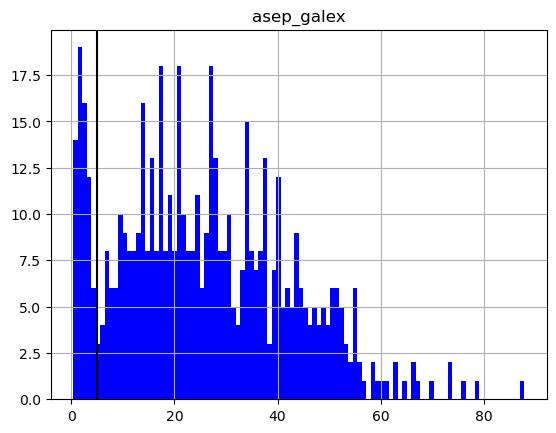

In [36]:
df.hist("asep_galex",bins=100,color="b")
plt.axvline(5,c="k")

array([[<AxesSubplot:title={'center':'asep_kids'}>]], dtype=object)

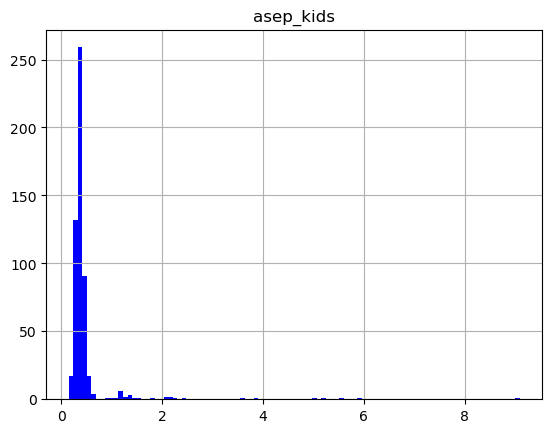

In [37]:
df.hist("asep_kids",bins=100,color='b')

## Select  Those spectra having GALEX

In [38]:
df = df[df["asep_galex"] < 5]

In [39]:
# reindex
df['index0'] = df.index
df = df.reset_index()

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_7795/1766426999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index0'] = df.index


In [40]:
df

index  num        ra       dec   Rmag  redshift   ra_galex  dec_galex  \
0      13   36  13.56870 -28.43129  19.96   0.82266  13.568381 -28.431563   
1      38   85  13.53755 -28.38375  23.21   0.97900  13.538054 -28.383455   
2      70  151  13.54459 -28.38795  22.23   0.49762  13.544825 -28.388740   
3      98  214  13.54850 -28.42296  19.80   0.29266  13.548439 -28.422414   
4      99  218  13.54348 -28.43490  21.27   0.43800  13.542637 -28.435506   
..    ...  ...       ...       ...    ...       ...        ...        ...   
63    533  722  13.69932 -28.26123  20.99   1.21050  13.699529 -28.261452   
64    535  724  13.66411 -28.25705  21.07   0.23168  13.664060 -28.257300   
65    536  725  13.69168 -28.25586  20.86   0.23010  13.692175 -28.256077   
66    538  727  13.69381 -28.25005  22.59   0.23060  13.694120 -28.250854   
67    543  732  13.71984 -28.23666  19.24   0.16176  13.720007 -28.237117   

      fuv_mag    nuv_mag  ...  FLUXERR_GAAP_Ks   Z_B  Z_ML  EXTINCTION_u  \
0         NaN  21.742678  ...       660.577942  1.00  1.00      0.075650   
1   21.637587        NaN  ...       609.571655  0.60  1.52      0.080195   
2         NaN  22.456930  ...       628.552673  0.86  1.21      0.080068   
3         NaN  22.062637  ...       679.517578  0.23  0.23      0.076636   
4         NaN  21.881433  ...       740.847229  0.34  0.34      0.073811   
..        ...        ...  ...              ...   ...   ...           ...   
63        NaN  21.741745  ...       514.735779  0.43  0.43      0.071443   
64        NaN  22.904402  ...       480.001190  0.32  0.32      0.070691   
65        NaN  22.222341  ...       512.764404  0.19  0.18      0.071652   
66        NaN  22.122770  ...       536.854980  0.27  0.31      0.070389   
67  20.910881  21.309574  ...       565.901917  0.16  0.16      0.071652   

    EXTINCTION_g  EXTINCTION_r  EXTINCTION_i asep_kids  \
0       0.058946      0.040779      0.030303  0.149184   
1       0.062487      0.043228      0.032123  0.259839   
2       0.062388      0.043160      0.032072  0.403894   
3       0.059715      0.041310      0.030698  0.509869   
4       0.057513      0.039787      0.029566  0.380524   
..           ...           ...           ...       ...   
63      0.055668      0.038511      0.028618  0.407676   
64      0.055082      0.038105      0.028316  0.240256   
65      0.055831      0.038623      0.028701  0.358455   
66      0.054846      0.037942      0.028195  0.396801   
67      0.055831      0.038624      0.028701  0.392222   

                                                lines  index0  
0   b'[OII],H9,H8,K,H{beta},[OIII]                ...      13  
1   b'MgII,[OII],H                                ...      38  
2   b'[OII],K,H,H{beta}                           ...      70  
3   b'[OII],H10,H9,H8,K,H,H{beta},[OIII]          ...      98  
4   b'[OII]                                       ...      99  
..                                                ...     ...  
63  b'broad,MgII,(QSO)                            ...     533  
64  b'[OII],H8,H,H{beta},[OIII],H{alpha}          ...     535  
65  b'[OII],H{beta},[OIII],H{alpha}               ...     536  
66  b'[OII],[OIII],H{alpha}                       ...     538  
67  b'H,K,H{gamma},H{beta},[OIII],H{alpha},NII    ...     543  

[68 rows x 68 columns]

## Remove NaN

- remove those row with no FUV

In [41]:
#df = df.dropna()

## Remove rows with Rmag = 0

In [42]:
#df = df[df["Rmag"] > 0]

In [43]:
df.columns

Index(['index', 'num', 'ra', 'dec', 'Rmag', 'redshift', 'ra_galex',
       'dec_galex', 'fuv_mag', 'nuv_mag', 'fuv_magerr', 'nuv_magerr',
       'fuv_flux', 'nuv_flux', 'fuv_fluxerr', 'nuv_fluxerr', 'asep_galex',
       'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000', 'FLUX_RADIUS', 'CLASS_STAR',
       'MAG_GAAP_u', 'MAG_GAAP_g', 'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z',
       'MAG_GAAP_Y', 'MAG_GAAP_J', 'MAG_GAAP_H', 'MAG_GAAP_Ks',
       'MAGERR_GAAP_u', 'MAGERR_GAAP_g', 'MAGERR_GAAP_r', 'MAGERR_GAAP_i',
       'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_J', 'MAGERR_GAAP_H',
       'MAGERR_GAAP_Ks', 'FLUX_GAAP_u', 'FLUXERR_GAAP_u', 'FLUX_GAAP_g',
       'FLUXERR_GAAP_g', 'FLUX_GAAP_r', 'FLUXERR_GAAP_r', 'FLUX_GAAP_i',
       'FLUXERR_GAAP_i', 'FLUX_GAAP_Z', 'FLUXERR_GAAP_Z', 'FLUX_GAAP_Y',
       'FLUXERR_GAAP_Y', 'FLUX_GAAP_J', 'FLUXERR_GAAP_J', 'FLUX_GAAP_H',
       'FLUXERR_GAAP_H', 'FLUX_GAAP_Ks', 'FLUXERR_GAAP_Ks', 'Z_B', 'Z_ML',
       'EXTINCTION_u', 'EXTINCTION_g', 'EXTINCTION_

# Plot Spectra

https://en.wikipedia.org/wiki/Photometric_system

In [44]:
lambda_FUV = 1528.
lambda_NUV = 2271.
lambda_U = 3650.
lambda_B = 4450.
lambda_G = 4640.
lambda_R = 5580.
lambda_I = 8060.
lambda_Z = 9000.
lambda_Y = 10200.
lambda_J = 12200.
lambda_H = 16300.
lambda_K = 21900.
lambda_L = 34500.

WL = [lambda_FUV, lambda_NUV, lambda_B, lambda_G, lambda_R ,lambda_I, lambda_Z, lambda_Y, lambda_J, lambda_H, lambda_K ]

In [45]:
df

index  num        ra       dec   Rmag  redshift   ra_galex  dec_galex  \
0      13   36  13.56870 -28.43129  19.96   0.82266  13.568381 -28.431563   
1      38   85  13.53755 -28.38375  23.21   0.97900  13.538054 -28.383455   
2      70  151  13.54459 -28.38795  22.23   0.49762  13.544825 -28.388740   
3      98  214  13.54850 -28.42296  19.80   0.29266  13.548439 -28.422414   
4      99  218  13.54348 -28.43490  21.27   0.43800  13.542637 -28.435506   
..    ...  ...       ...       ...    ...       ...        ...        ...   
63    533  722  13.69932 -28.26123  20.99   1.21050  13.699529 -28.261452   
64    535  724  13.66411 -28.25705  21.07   0.23168  13.664060 -28.257300   
65    536  725  13.69168 -28.25586  20.86   0.23010  13.692175 -28.256077   
66    538  727  13.69381 -28.25005  22.59   0.23060  13.694120 -28.250854   
67    543  732  13.71984 -28.23666  19.24   0.16176  13.720007 -28.237117   

      fuv_mag    nuv_mag  ...  FLUXERR_GAAP_Ks   Z_B  Z_ML  EXTINCTION_u  \
0         NaN  21.742678  ...       660.577942  1.00  1.00      0.075650   
1   21.637587        NaN  ...       609.571655  0.60  1.52      0.080195   
2         NaN  22.456930  ...       628.552673  0.86  1.21      0.080068   
3         NaN  22.062637  ...       679.517578  0.23  0.23      0.076636   
4         NaN  21.881433  ...       740.847229  0.34  0.34      0.073811   
..        ...        ...  ...              ...   ...   ...           ...   
63        NaN  21.741745  ...       514.735779  0.43  0.43      0.071443   
64        NaN  22.904402  ...       480.001190  0.32  0.32      0.070691   
65        NaN  22.222341  ...       512.764404  0.19  0.18      0.071652   
66        NaN  22.122770  ...       536.854980  0.27  0.31      0.070389   
67  20.910881  21.309574  ...       565.901917  0.16  0.16      0.071652   

    EXTINCTION_g  EXTINCTION_r  EXTINCTION_i asep_kids  \
0       0.058946      0.040779      0.030303  0.149184   
1       0.062487      0.043228      0.032123  0.259839   
2       0.062388      0.043160      0.032072  0.403894   
3       0.059715      0.041310      0.030698  0.509869   
4       0.057513      0.039787      0.029566  0.380524   
..           ...           ...           ...       ...   
63      0.055668      0.038511      0.028618  0.407676   
64      0.055082      0.038105      0.028316  0.240256   
65      0.055831      0.038623      0.028701  0.358455   
66      0.054846      0.037942      0.028195  0.396801   
67      0.055831      0.038624      0.028701  0.392222   

                                                lines  index0  
0   b'[OII],H9,H8,K,H{beta},[OIII]                ...      13  
1   b'MgII,[OII],H                                ...      38  
2   b'[OII],K,H,H{beta}                           ...      70  
3   b'[OII],H10,H9,H8,K,H,H{beta},[OIII]          ...      98  
4   b'[OII]                                       ...      99  
..                                                ...     ...  
63  b'broad,MgII,(QSO)                            ...     533  
64  b'[OII],H8,H,H{beta},[OIII],H{alpha}          ...     535  
65  b'[OII],H{beta},[OIII],H{alpha}               ...     536  
66  b'[OII],[OIII],H{alpha}                       ...     538  
67  b'H,K,H{gamma},H{beta},[OIII],H{alpha},NII    ...     543  

[68 rows x 68 columns]

In [46]:
df.columns

Index(['index', 'num', 'ra', 'dec', 'Rmag', 'redshift', 'ra_galex',
       'dec_galex', 'fuv_mag', 'nuv_mag', 'fuv_magerr', 'nuv_magerr',
       'fuv_flux', 'nuv_flux', 'fuv_fluxerr', 'nuv_fluxerr', 'asep_galex',
       'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000', 'FLUX_RADIUS', 'CLASS_STAR',
       'MAG_GAAP_u', 'MAG_GAAP_g', 'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z',
       'MAG_GAAP_Y', 'MAG_GAAP_J', 'MAG_GAAP_H', 'MAG_GAAP_Ks',
       'MAGERR_GAAP_u', 'MAGERR_GAAP_g', 'MAGERR_GAAP_r', 'MAGERR_GAAP_i',
       'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_J', 'MAGERR_GAAP_H',
       'MAGERR_GAAP_Ks', 'FLUX_GAAP_u', 'FLUXERR_GAAP_u', 'FLUX_GAAP_g',
       'FLUXERR_GAAP_g', 'FLUX_GAAP_r', 'FLUXERR_GAAP_r', 'FLUX_GAAP_i',
       'FLUXERR_GAAP_i', 'FLUX_GAAP_Z', 'FLUXERR_GAAP_Z', 'FLUX_GAAP_Y',
       'FLUXERR_GAAP_Y', 'FLUX_GAAP_J', 'FLUXERR_GAAP_J', 'FLUX_GAAP_H',
       'FLUXERR_GAAP_H', 'FLUX_GAAP_Ks', 'FLUXERR_GAAP_Ks', 'Z_B', 'Z_ML',
       'EXTINCTION_u', 'EXTINCTION_g', 'EXTINCTION_

## Plot Magnitude correlation

In [47]:
df_rmag = df[df["Rmag"] > 0]

<AxesSubplot:title={'center':'Kids R magnitude vs Fors2 R Petrosian magnitude'}, xlabel='Rmag', ylabel='MAG_GAAP_r'>

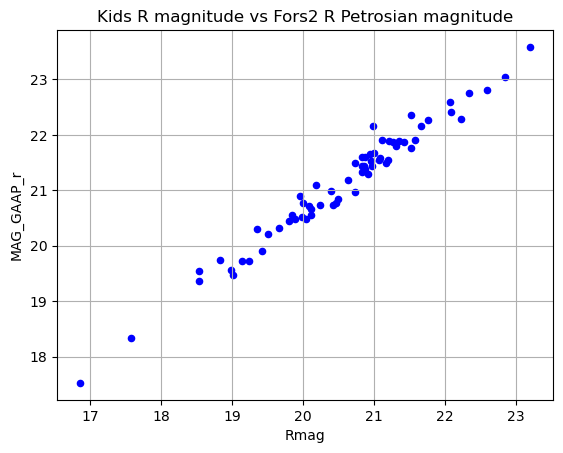

In [48]:
df_rmag.plot.scatter(x="Rmag",y="MAG_GAAP_r",color="b",title="Kids R magnitude vs Fors2 R Petrosian magnitude",grid=True)

# Plots spectra

index: 0  ==> SPEC 36
b'[OII],H9,H8,K,H{beta},[OIII]                                                \r'


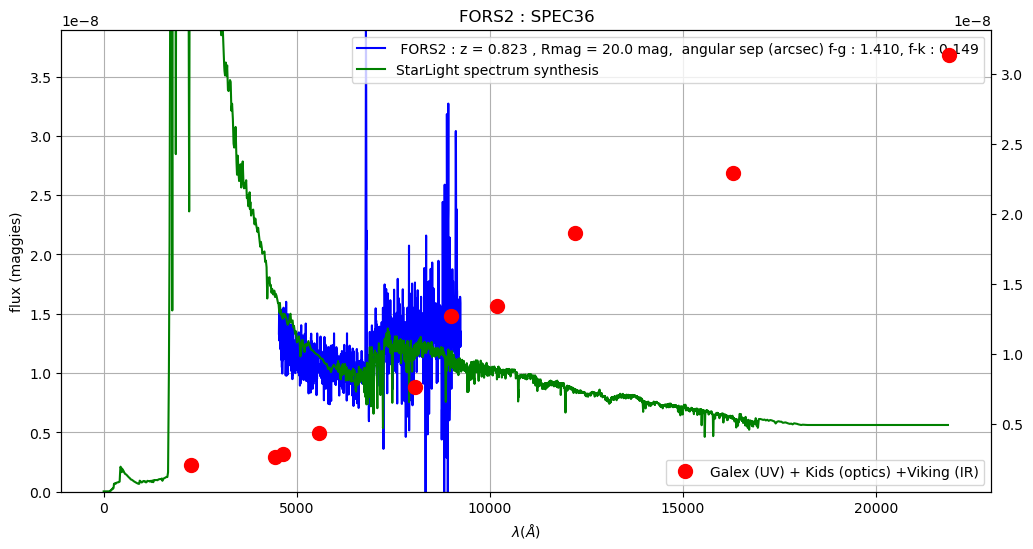

index: 1  ==> SPEC 85
b'MgII,[OII],H                                                                \r'


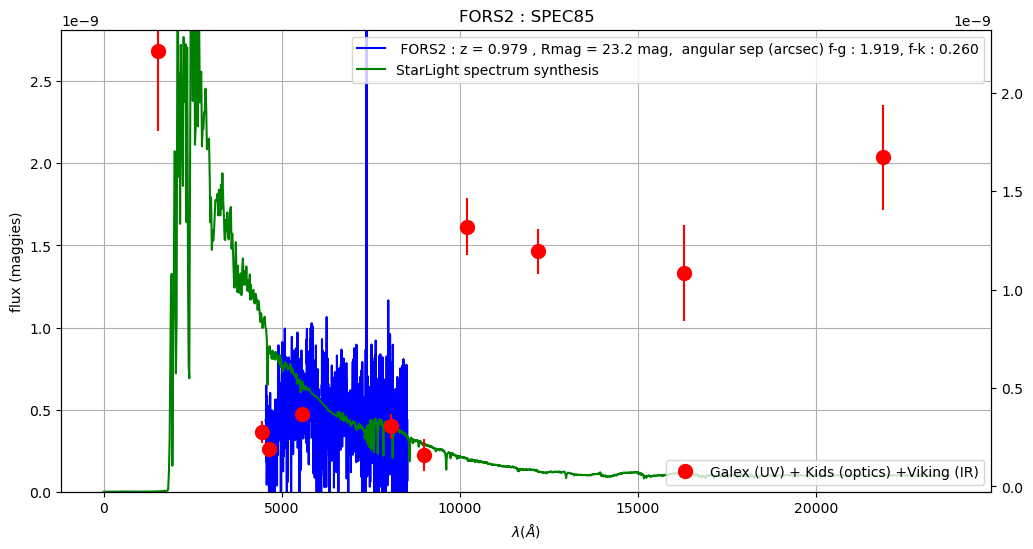

index: 2  ==> SPEC 151
b'[OII],K,H,H{beta}                                                           \r'


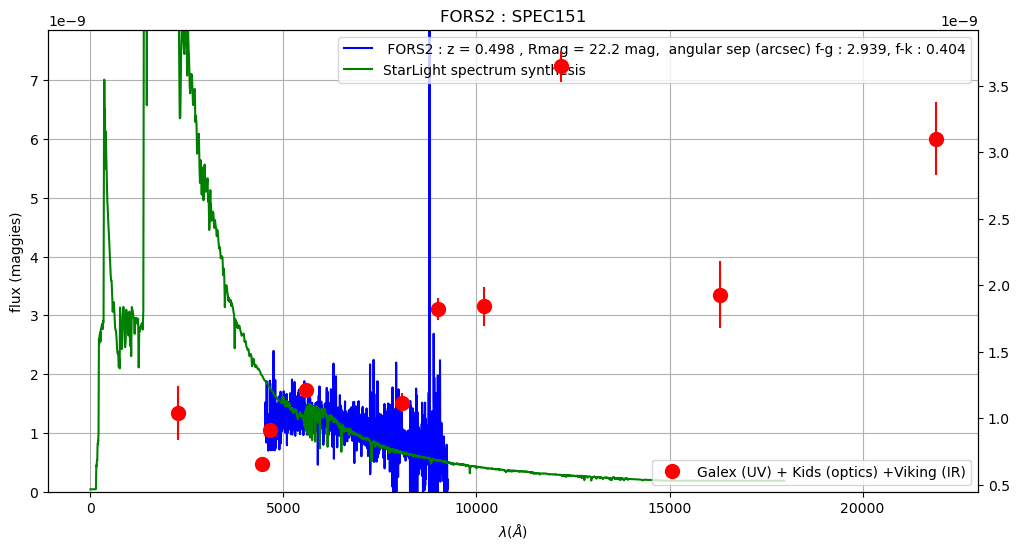

index: 3  ==> SPEC 214
b'[OII],H10,H9,H8,K,H,H{beta},[OIII]                                          \r'


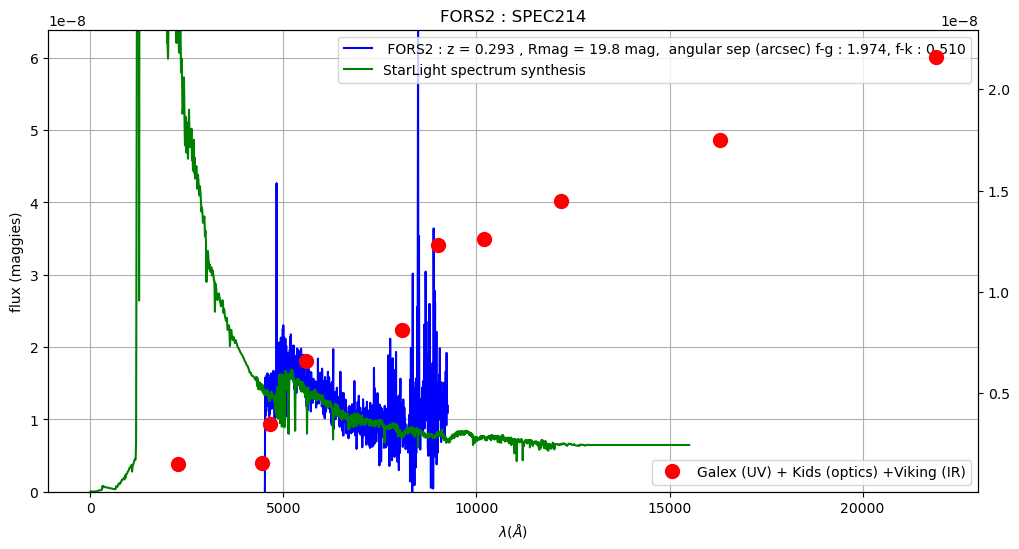

index: 4  ==> SPEC 218
b'[OII]                                                                       \r'


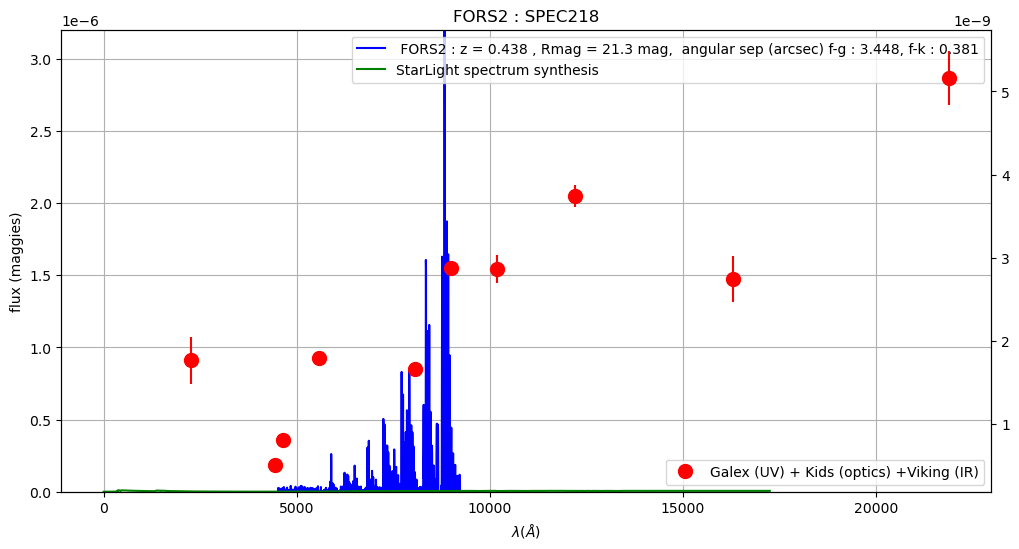

index: 5  ==> SPEC 242
b'[OIII],H{alpha}                                                             \r'


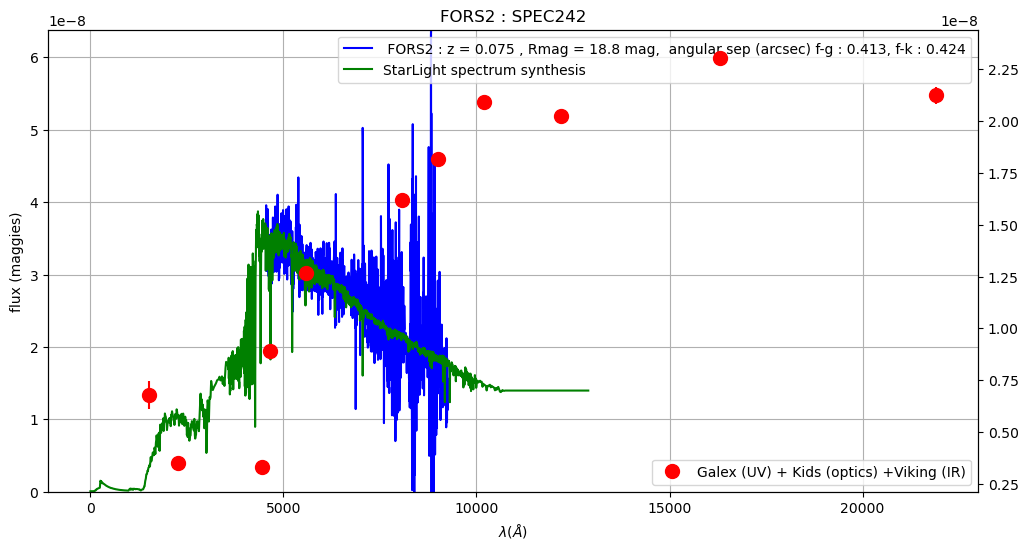

index: 6  ==> SPEC 306
b'MgII,[OII],H10,H9,K                                                         \r'


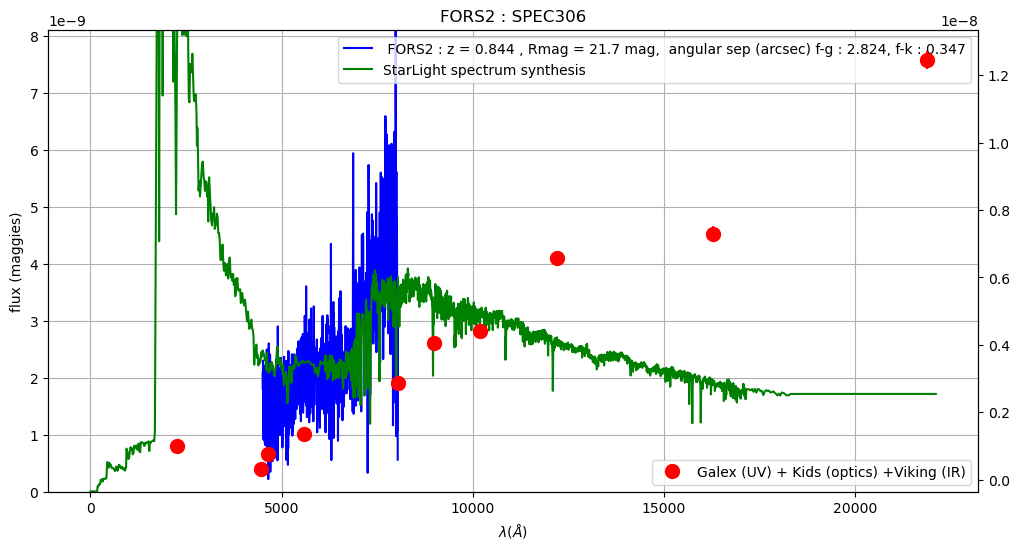

index: 7  ==> SPEC 307
b'[OII],H{alpha}                                                              \r'


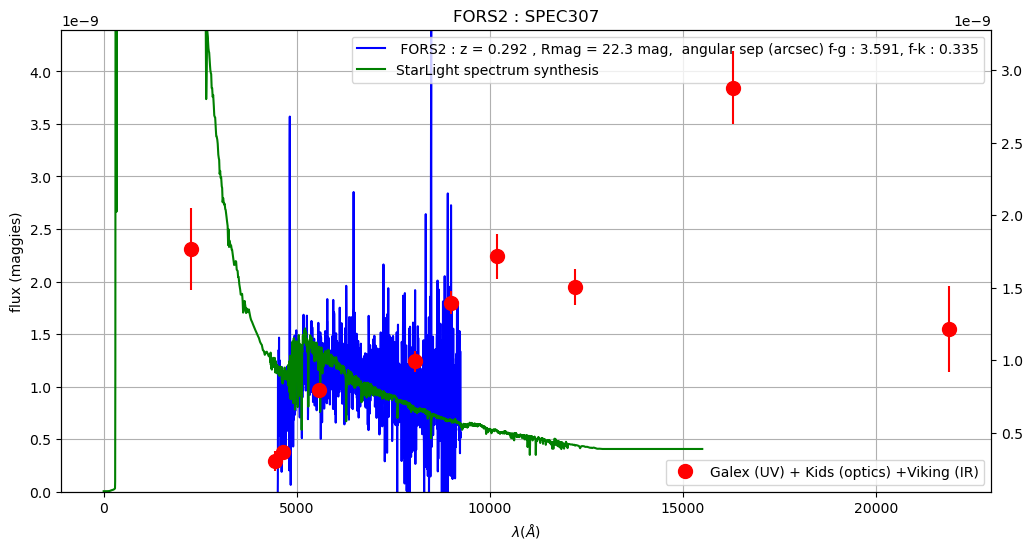

index: 8  ==> SPEC 315
b'[OII],H{beta}                                                               \r'


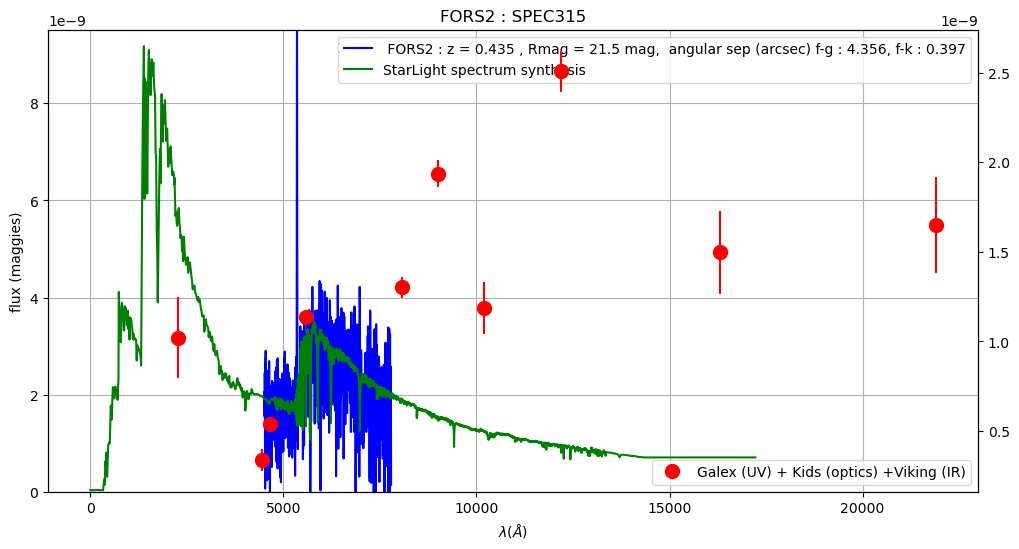

index: 9  ==> SPEC 325
b'[OII],H10,H9,H8,H,H{delta},H{beta},[OIII],H{alpha}                          \r'


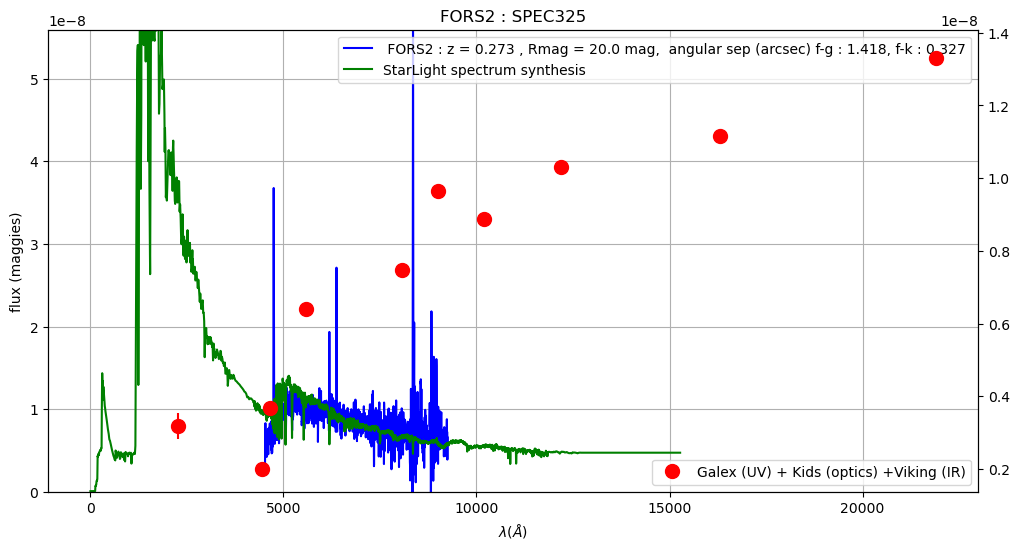

index: 10  ==> SPEC 326
b'[OII],H9,K,H,[OIII],H{alpha}                                                \r'


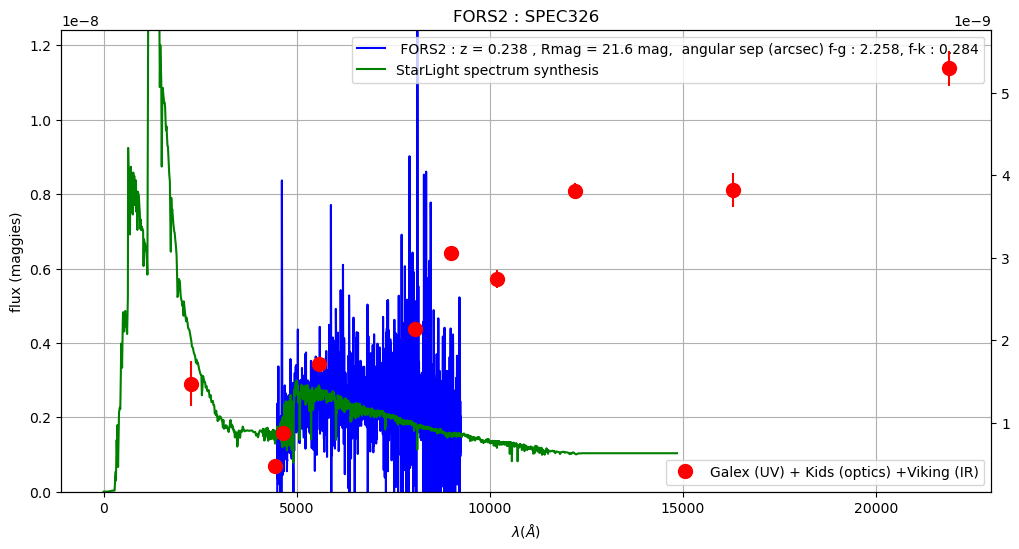

index: 11  ==> SPEC 337
b'[OII],H                                                                     \r'


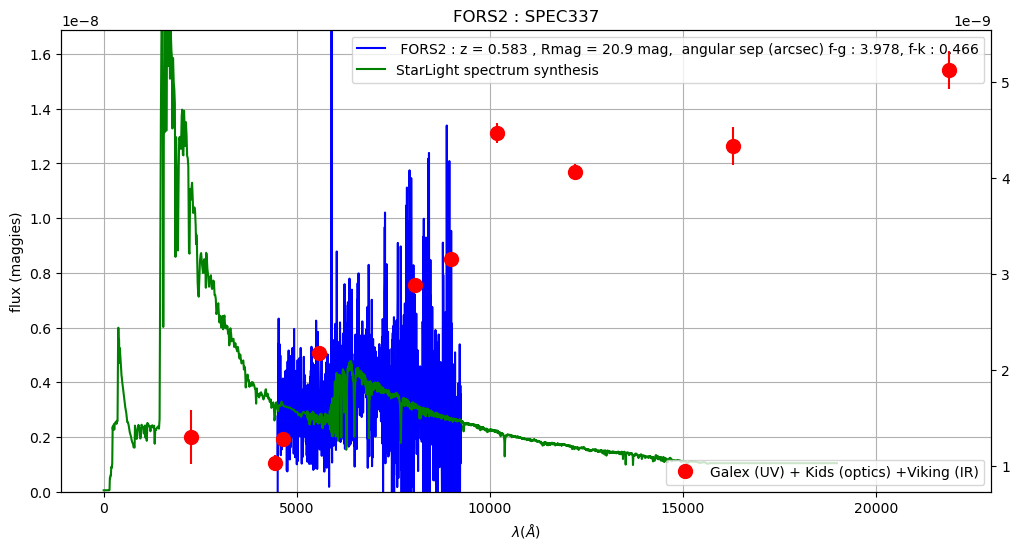

index: 12  ==> SPEC 350
b'[OII],H{beta},[OIII]                                                        \r'


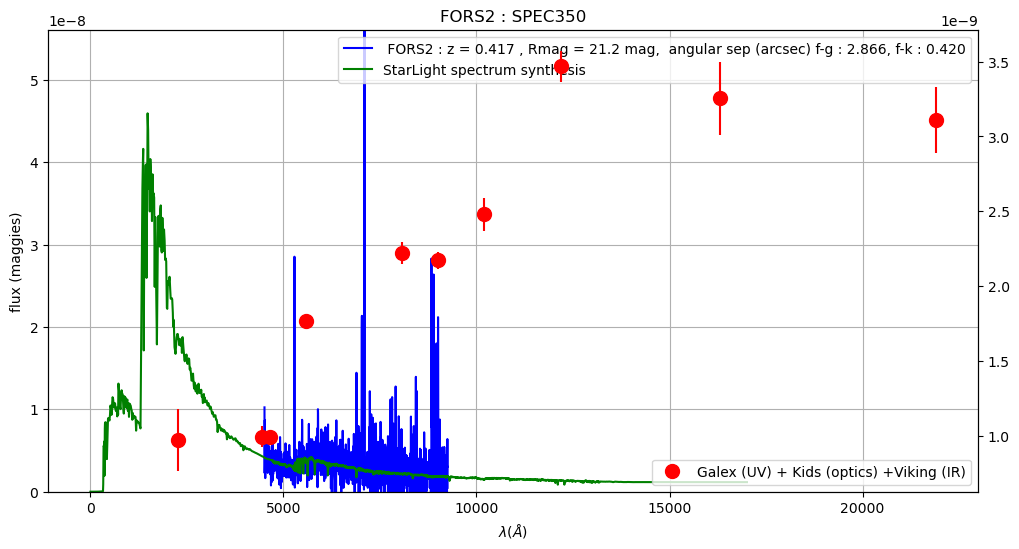

index: 13  ==> SPEC 363
b'H9,H8,H,H{delta},[OIII],H{alpha}                                            \r'


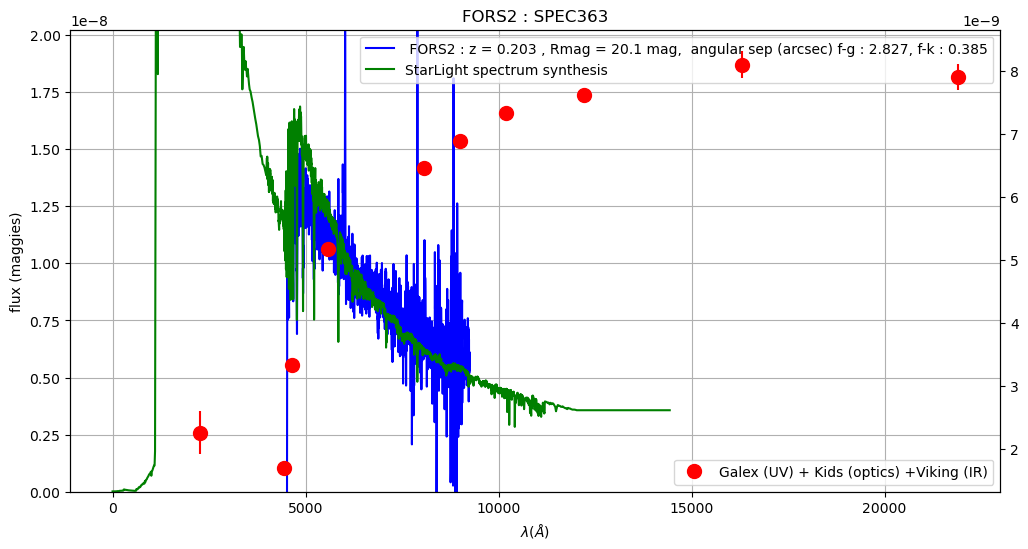

index: 14  ==> SPEC 368
b'[OII],H{delta},H{beta},[OIII]                                               \r'


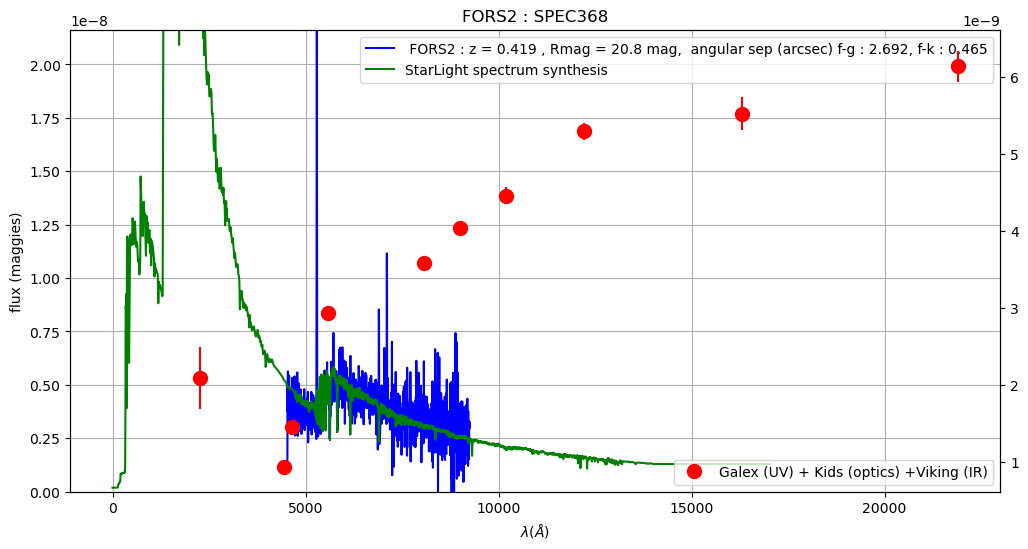

index: 15  ==> SPEC 373
b'[OII],H9,K,H,H{beta},[OIII],H{alpha}                                        \r'


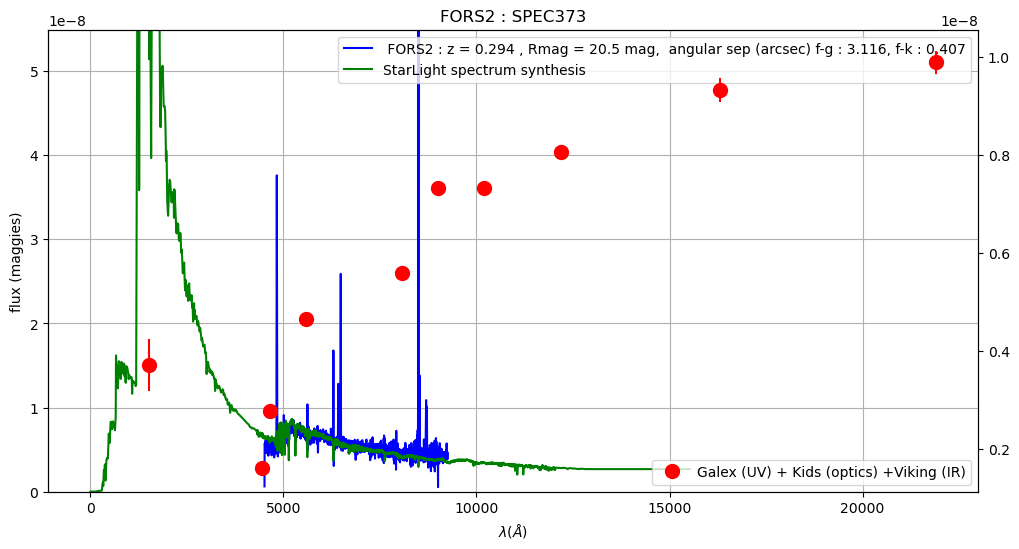

index: 16  ==> SPEC 386
b'[OII],H,H{delta}                                                            \r'


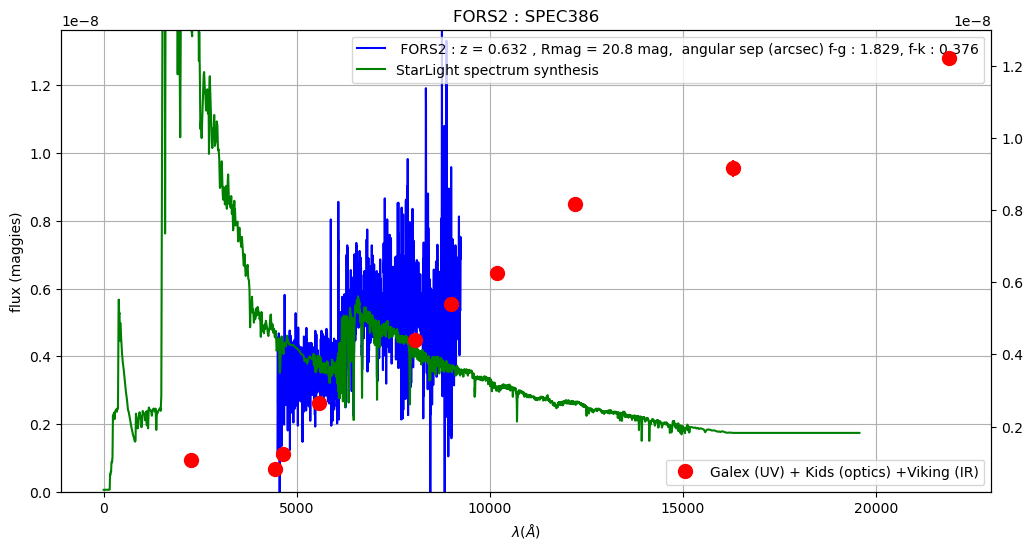

index: 17  ==> SPEC 390
b'[OII],H,H{beta},[OIII]                                                      \r'


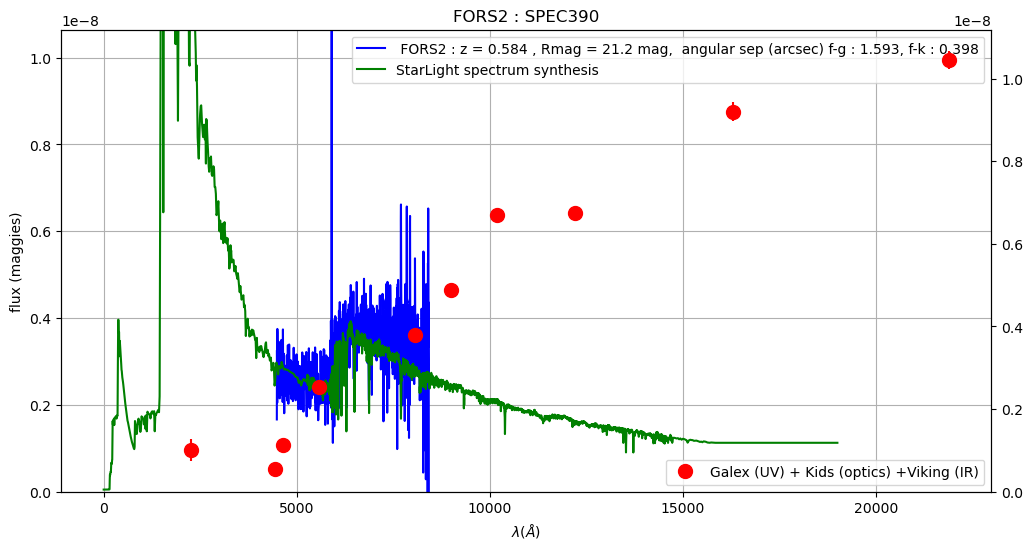

index: 18  ==> SPEC 399
b'[OII],H{gamma},H{beta},[OIII],H{alpha}                                      \r'


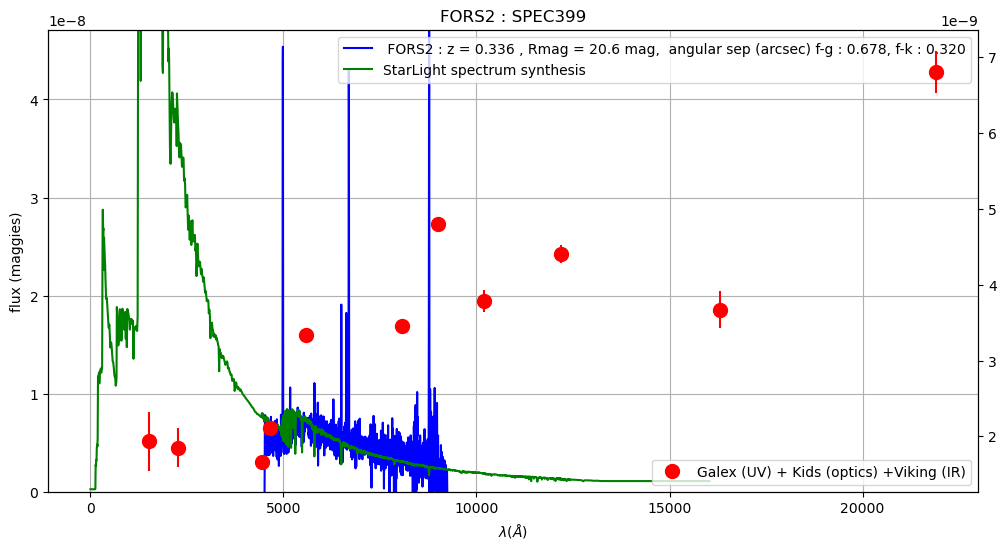

index: 19  ==> SPEC 401
b'[OII],H,H{beta}                                                             \r'


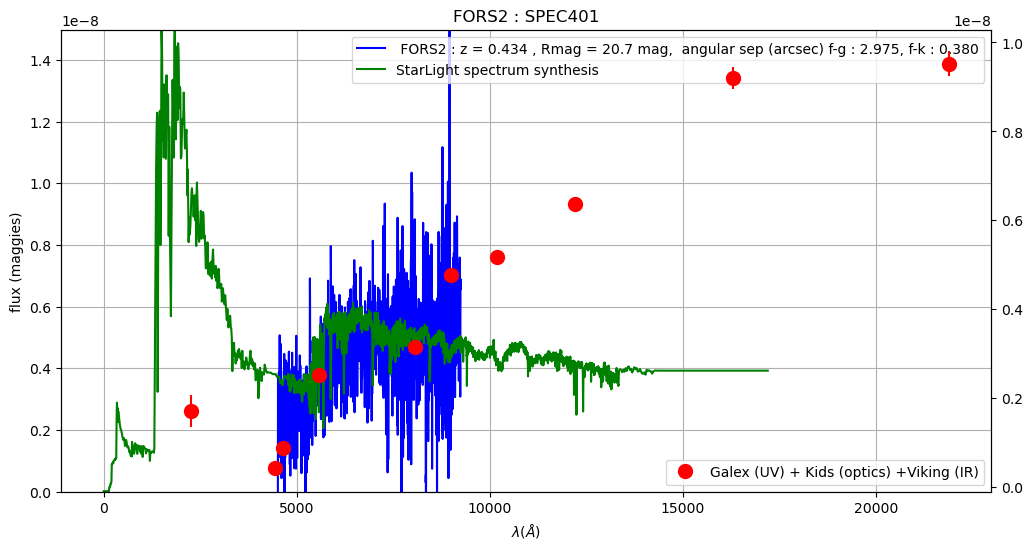

index: 20  ==> SPEC 402
b'[OII],H9,K,H,H{delta}                                                       \r'


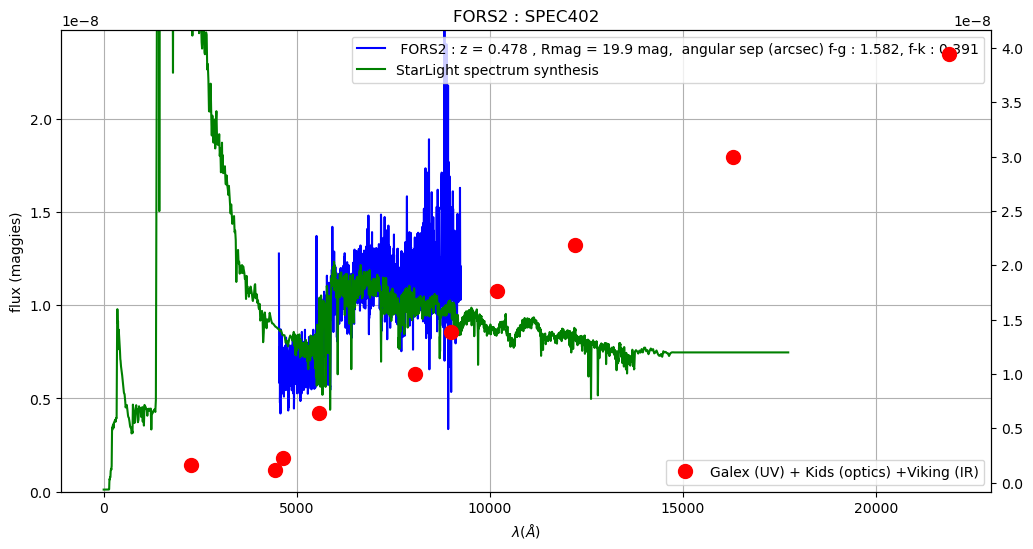

index: 21  ==> SPEC 403
b'[OII],H,H{alpha}                                                            \r'


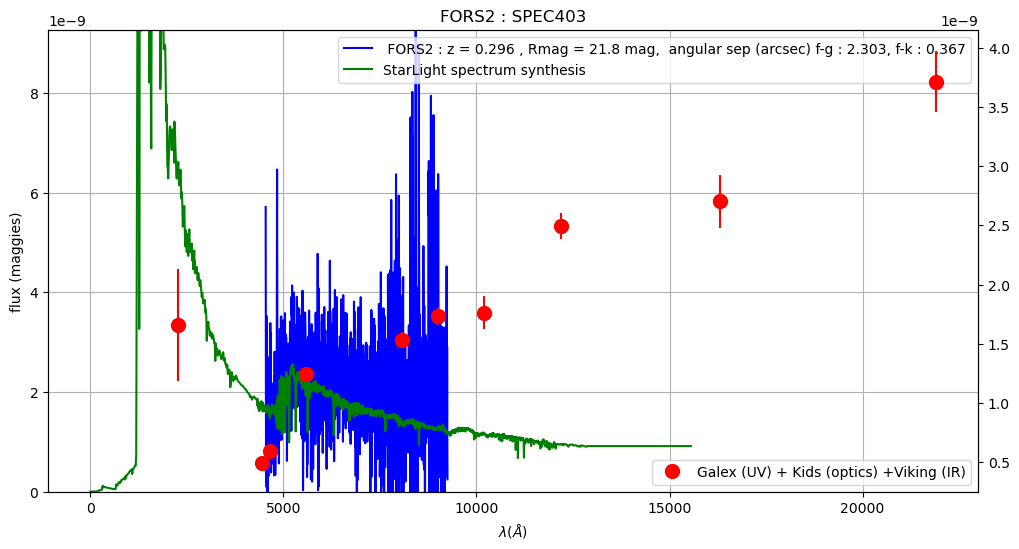

index: 22  ==> SPEC 411
b'[OII],H8,K,H,H{delta}                                                       \r'


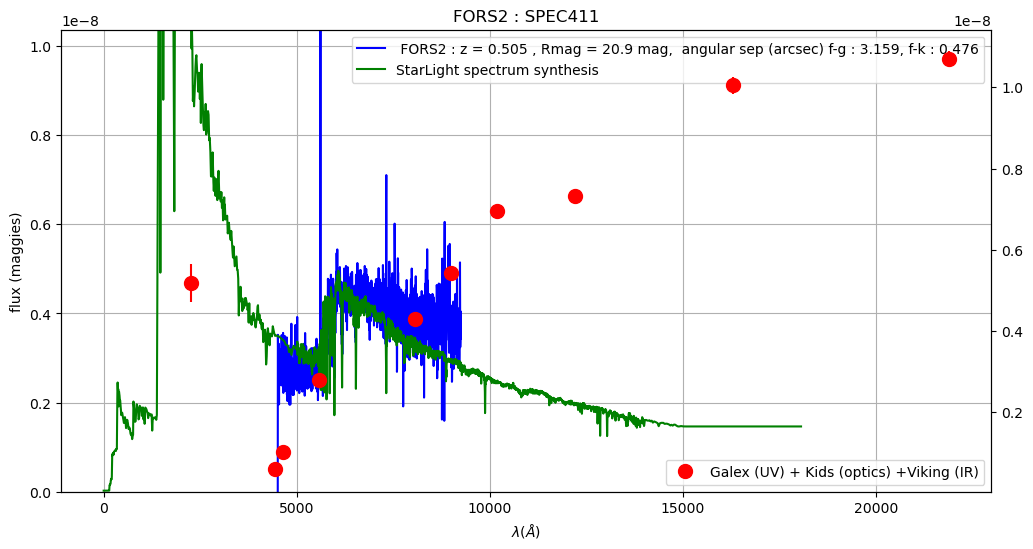

index: 23  ==> SPEC 414
b'MgII,[OII],H10,H9,H8,H,H{delta}                                             \r'


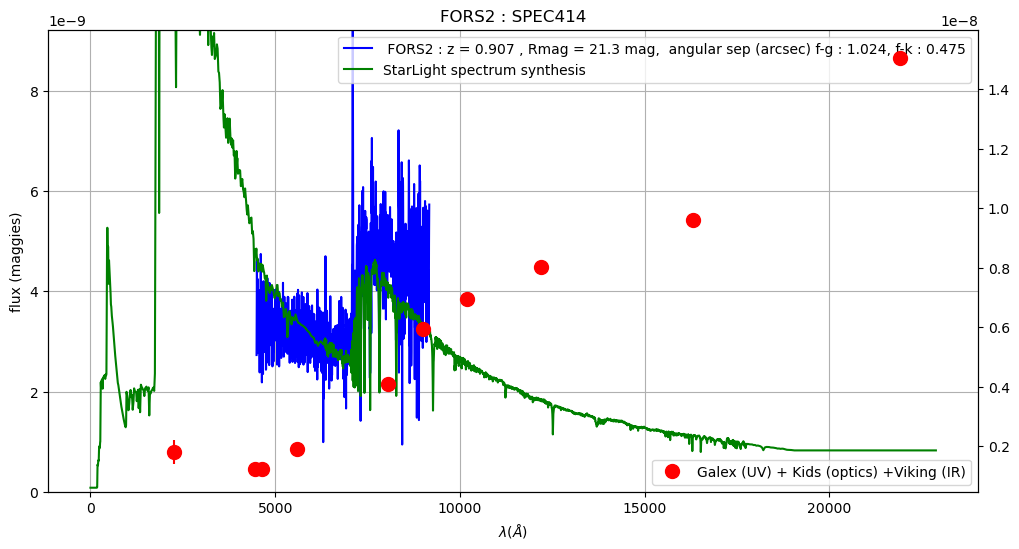

index: 24  ==> SPEC 415
b'[OIII],H{alpha}                                                             \r'


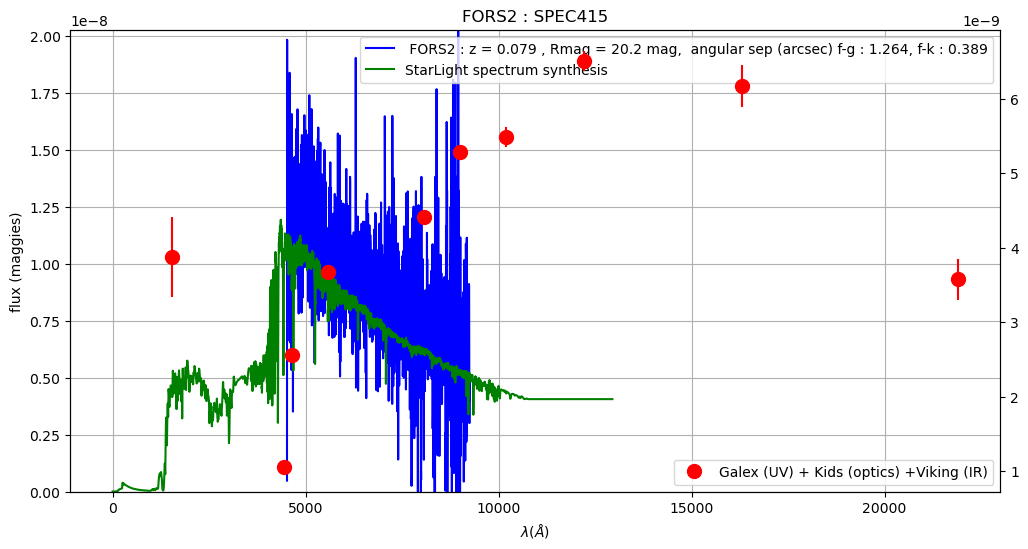

index: 25  ==> SPEC 421
b'H{beta},[OIII],H{alpha}                                                     \r'


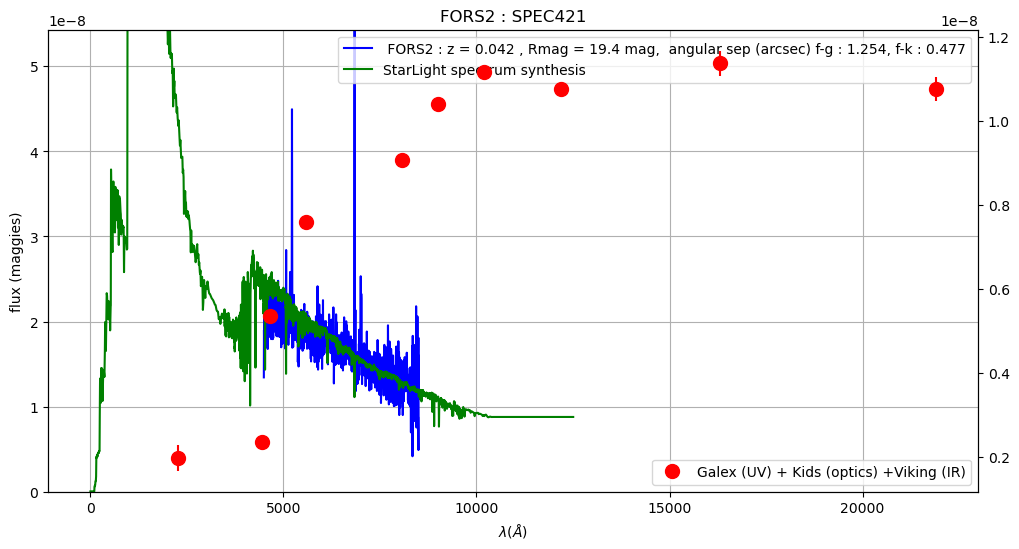

index: 26  ==> SPEC 434
b'[OII],H{beta},[OIII],H{alpha}                                               \r'


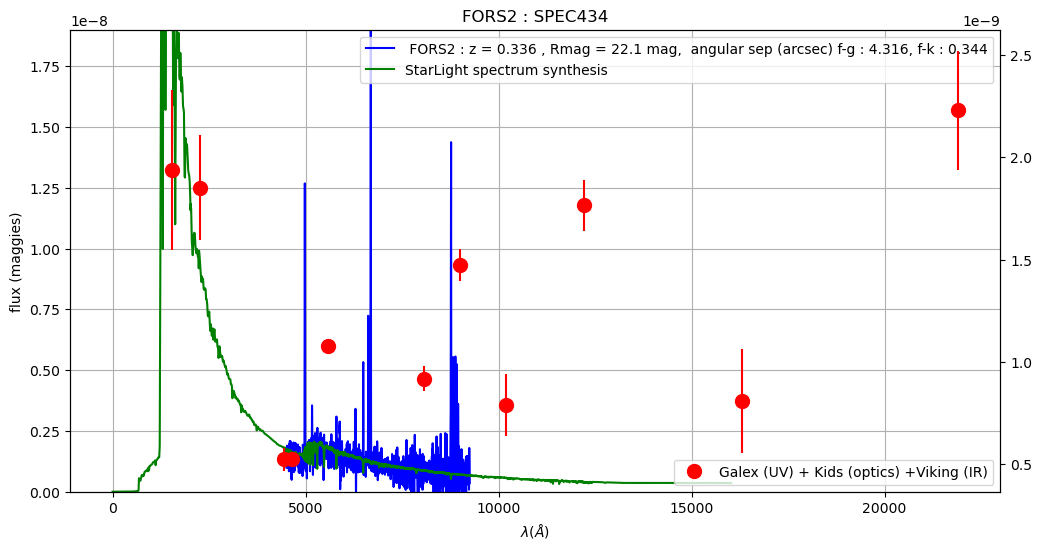

index: 27  ==> SPEC 435
b'[OII],K,H,H{beta},[OIII],H{alpha}                                           \r'


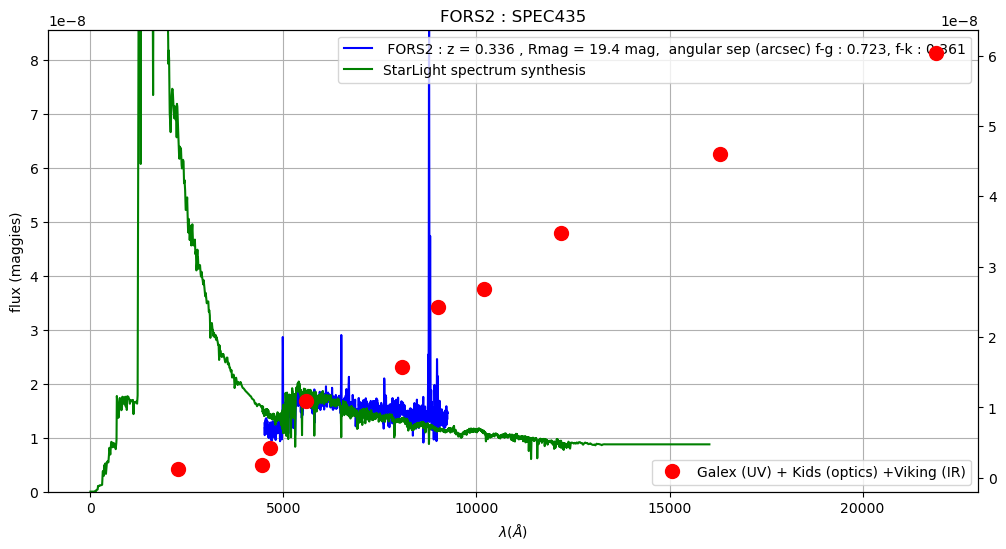

index: 28  ==> SPEC 437
b'[OII],H{beta},[OIII],H{alpha}                                               \r'


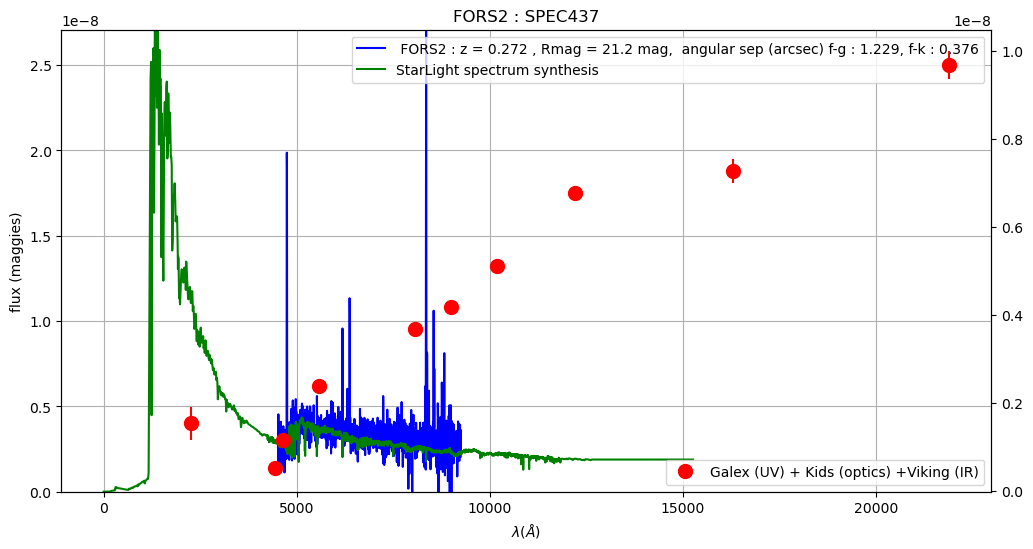

index: 29  ==> SPEC 444
b'[OII],K,H,H{beta}                                                           \r'


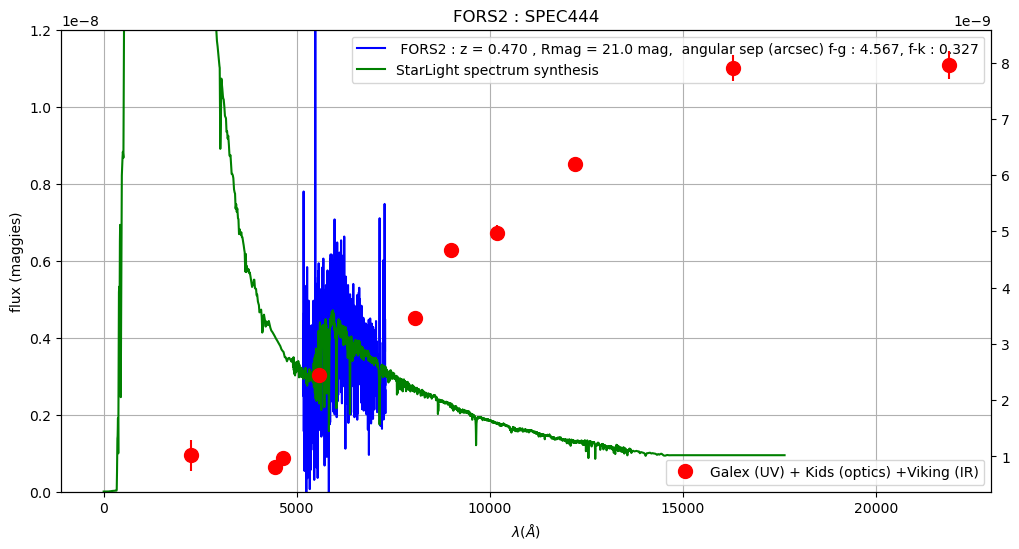

index: 30  ==> SPEC 451
b'K,H,4000{AA}-break,H{delta}                                                 \r'


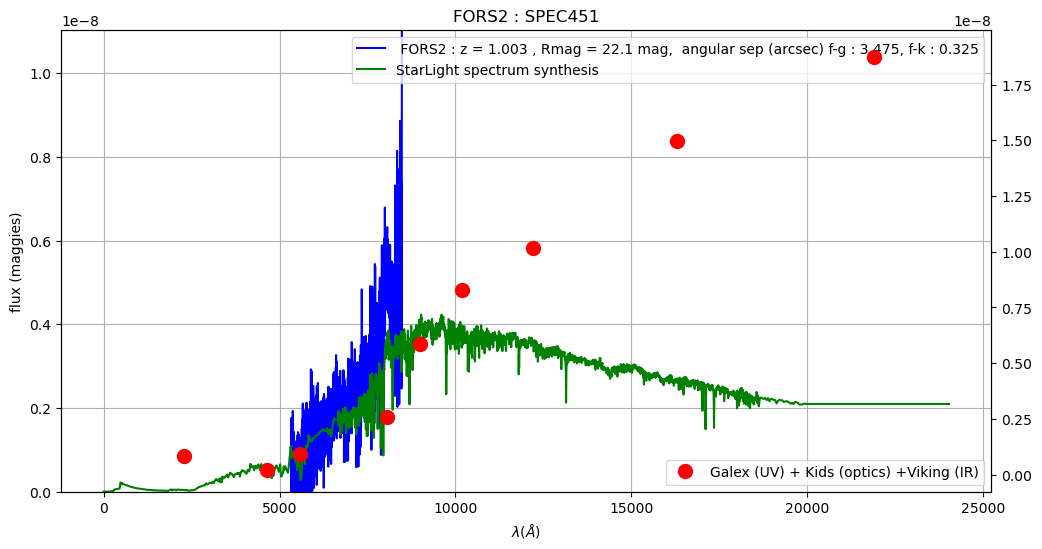

index: 31  ==> SPEC 471
b'[OII],H{beta},[OIII]                                                        \r'


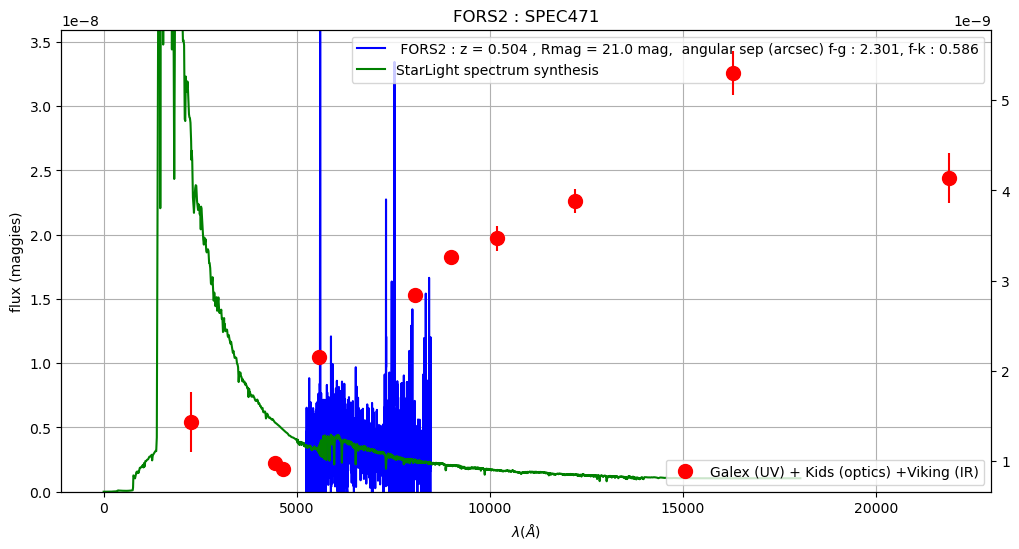

index: 32  ==> SPEC 472
b'[OII],H{beta},[OIII]                                                        \r'


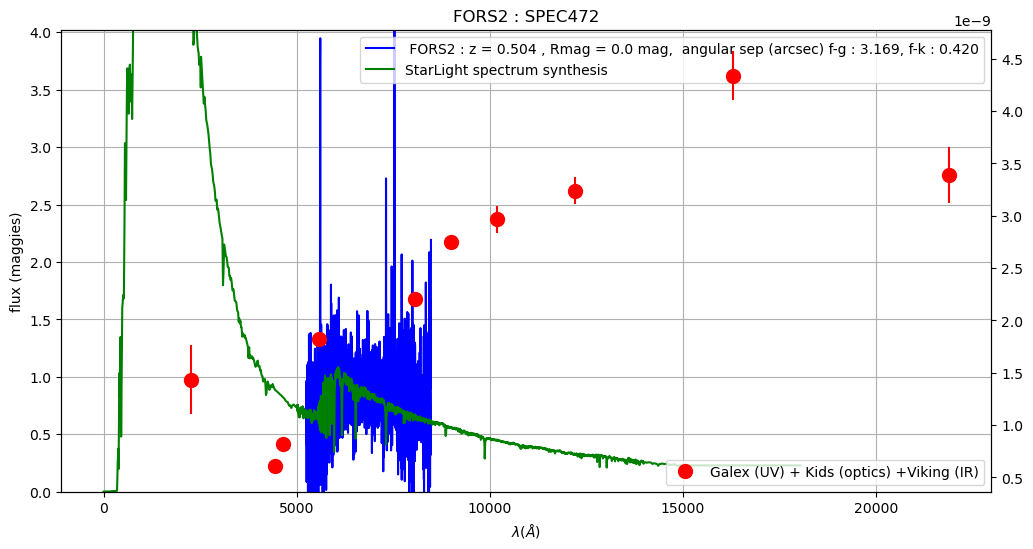

index: 33  ==> SPEC 476
b'[OIII],H{alpha}                                                             \r'


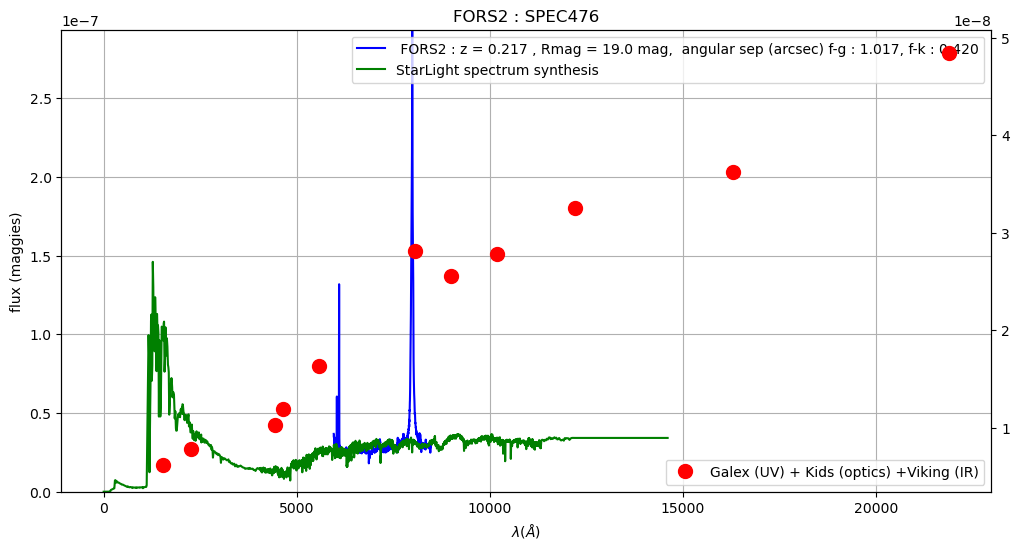

index: 34  ==> SPEC 499
b'[OII],H{beta},[OIII]                                                        \r'


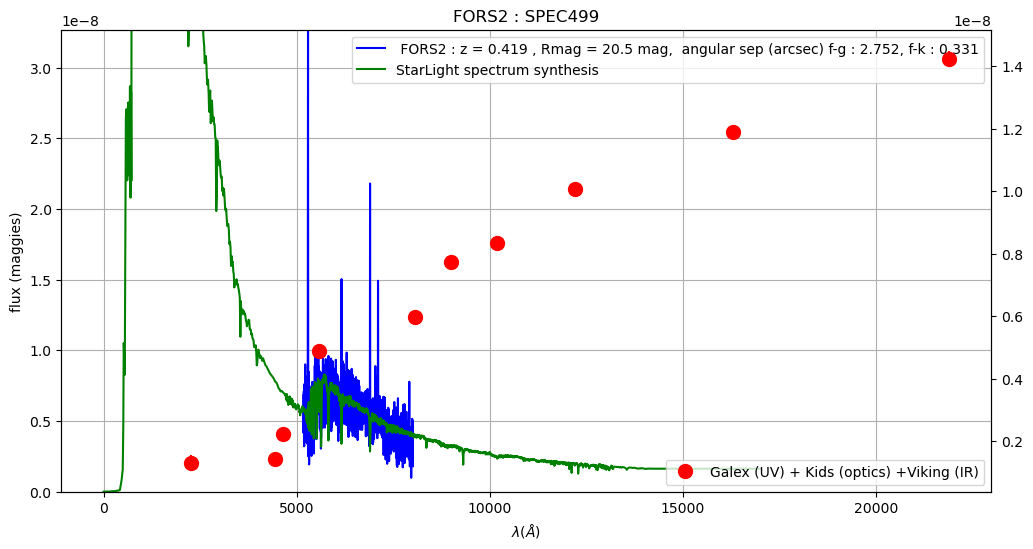

index: 35  ==> SPEC 516
b'                                                                            \r'


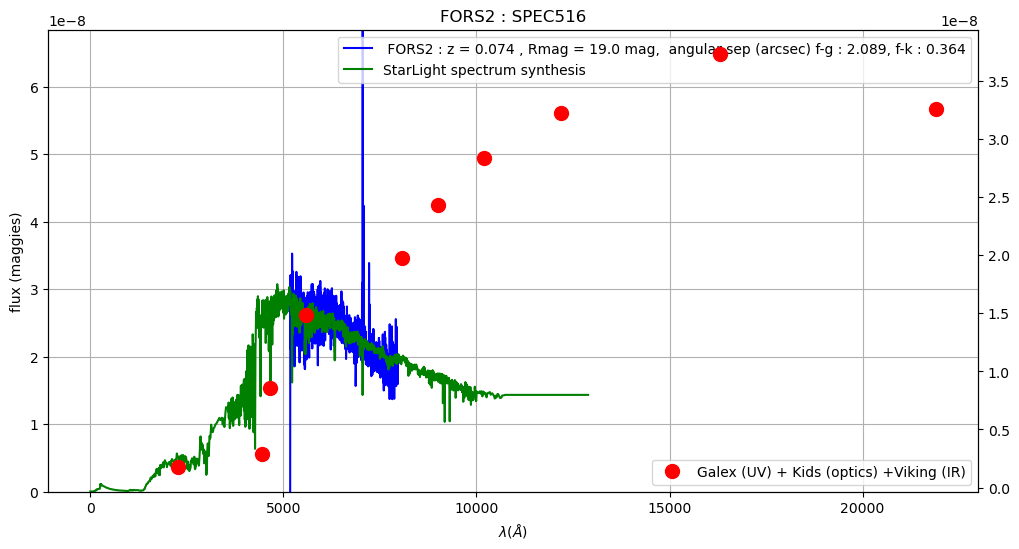

index: 36  ==> SPEC 519
b'K,H,G,Fe43,Fe45,H{beta},Mgb                                                 \r'


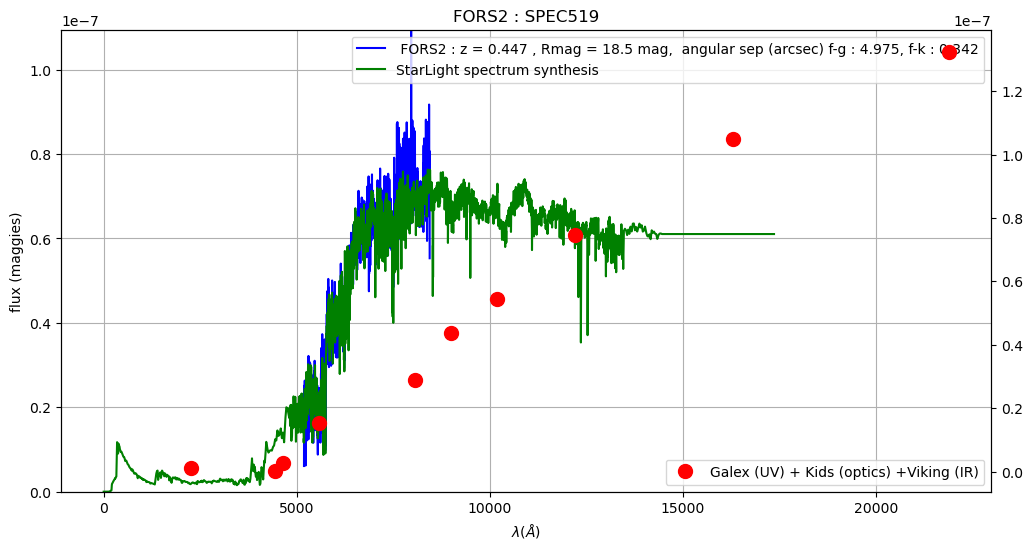

index: 37  ==> SPEC 558
b'[OII],H9,K,H,H{beta},[OIII]                                                 \r'


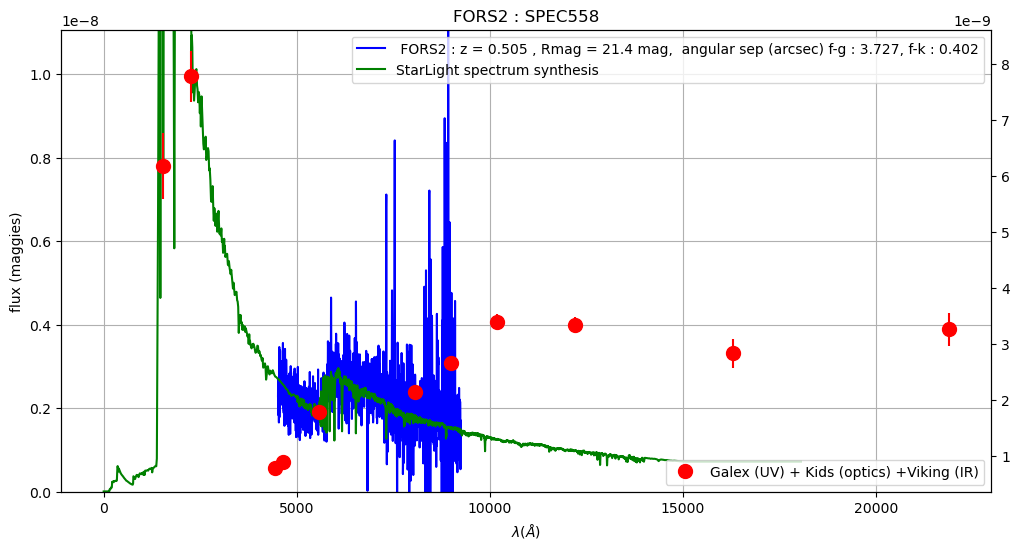

index: 38  ==> SPEC 560
b'G,H{beta},Mgb,NaD                                                           \r'


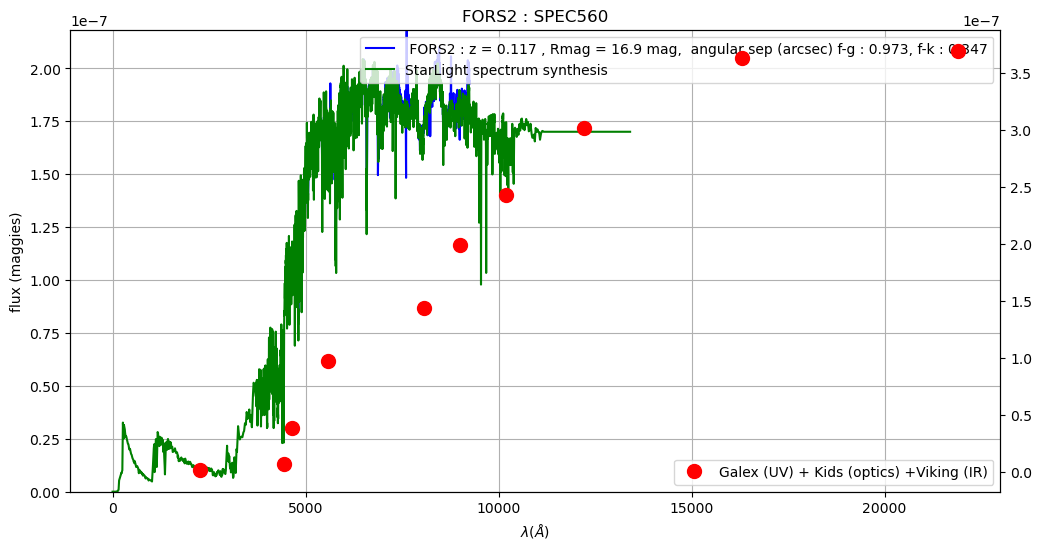

index: 39  ==> SPEC 563
b'H{delta},G,Mgb,NaD,H{alpha}                                                 \r'


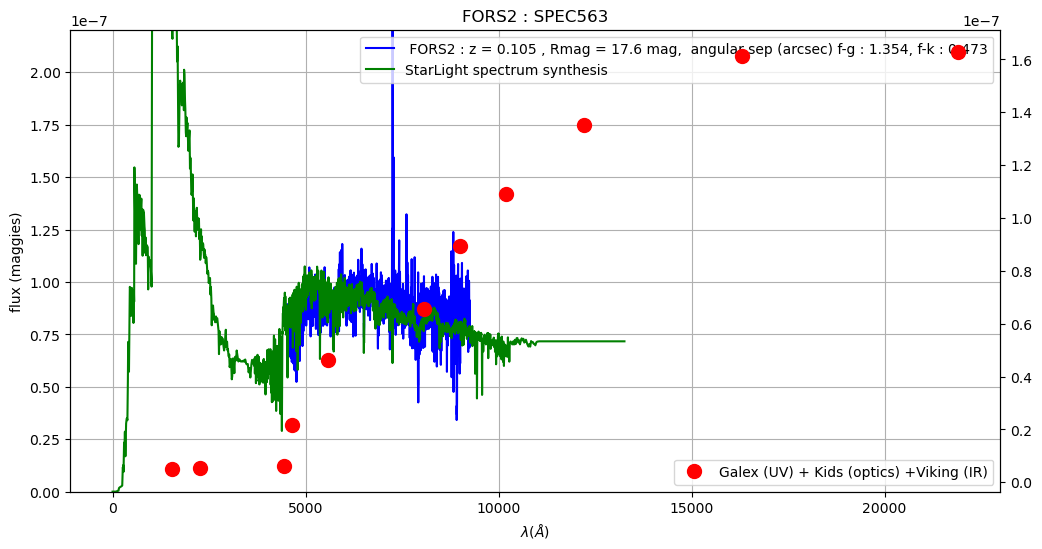

index: 40  ==> SPEC 564
b'[OII],H{delta},H{gamma},H{beta},[OIII],H{alpha}                             \r'


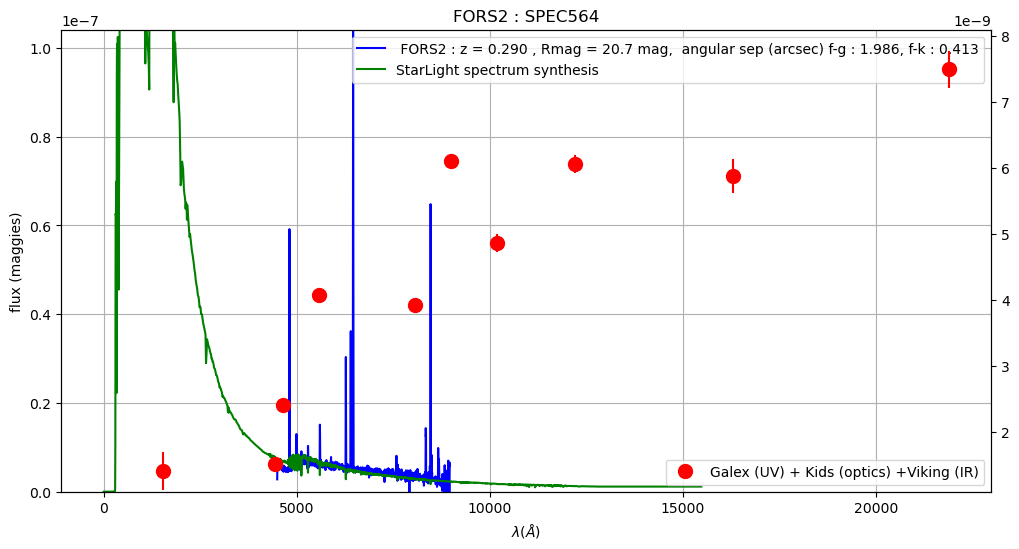

index: 41  ==> SPEC 572
b'[OII],H10,H9,H8,K,H,H{beta},[OIII],H{alpha}                                 \r'


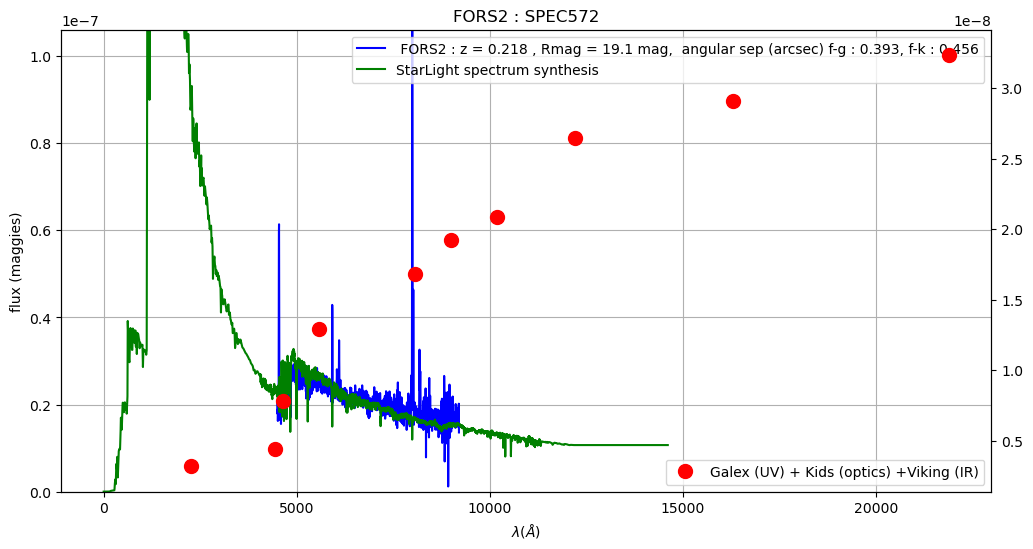

index: 42  ==> SPEC 587
b'[OII],H9,H,H{beta},[OIII]                                                   \r'


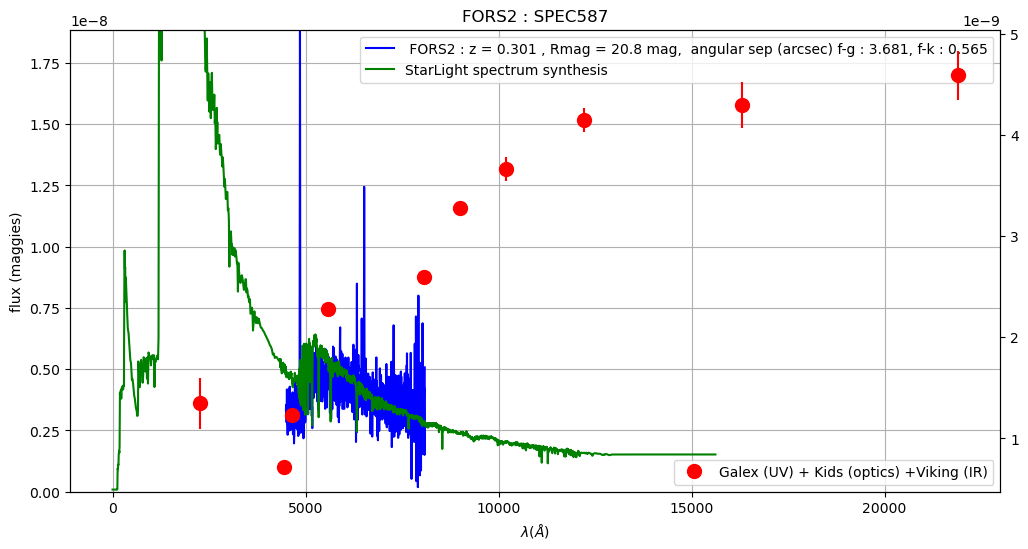

index: 43  ==> SPEC 589
b'[OII],H9,H,H{delta}                                                         \r'


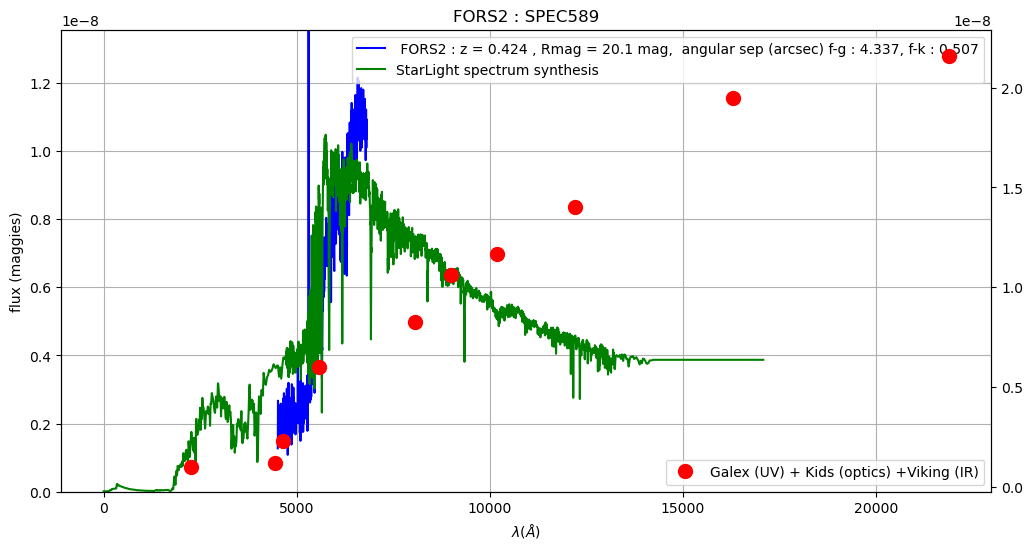

index: 44  ==> SPEC 591
b'broad,MgII,[OII],(QSO)                                                      \r'


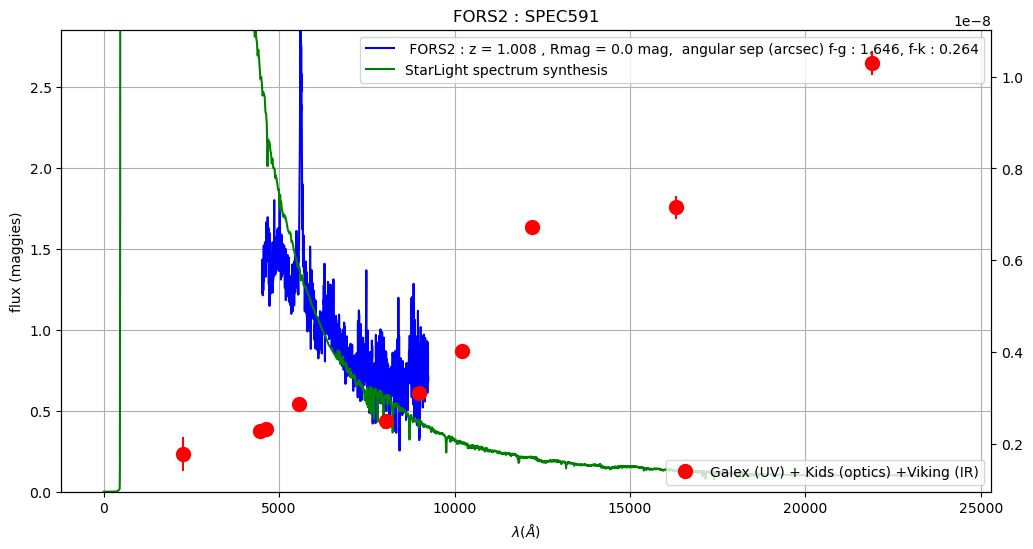

index: 45  ==> SPEC 595
b'[OII],H11,H10,H9,H8,K,H,H{delta},H{beta},[OIII]                             \r'


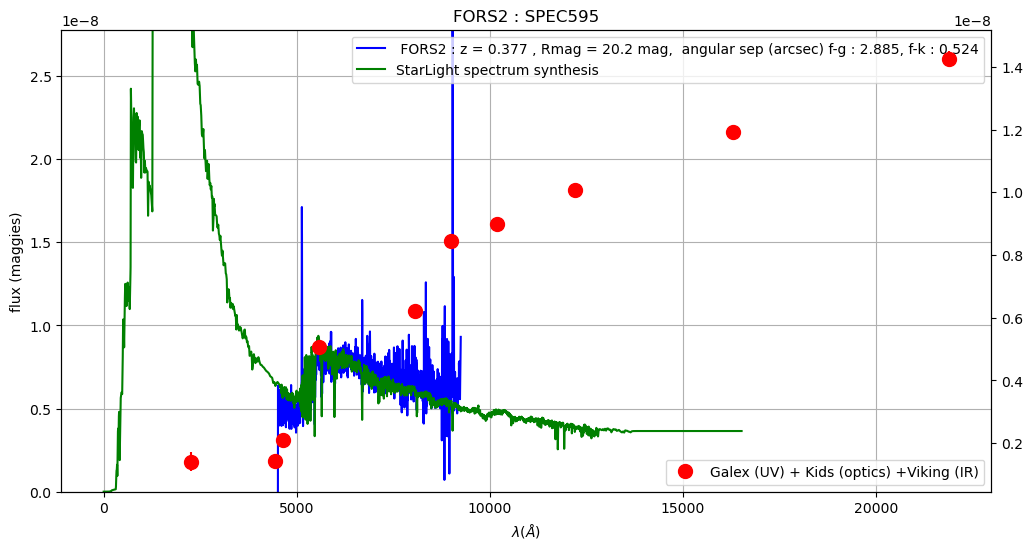

index: 46  ==> SPEC 604
b'H{beta},[OIII],H{alpha}                                                     \r'


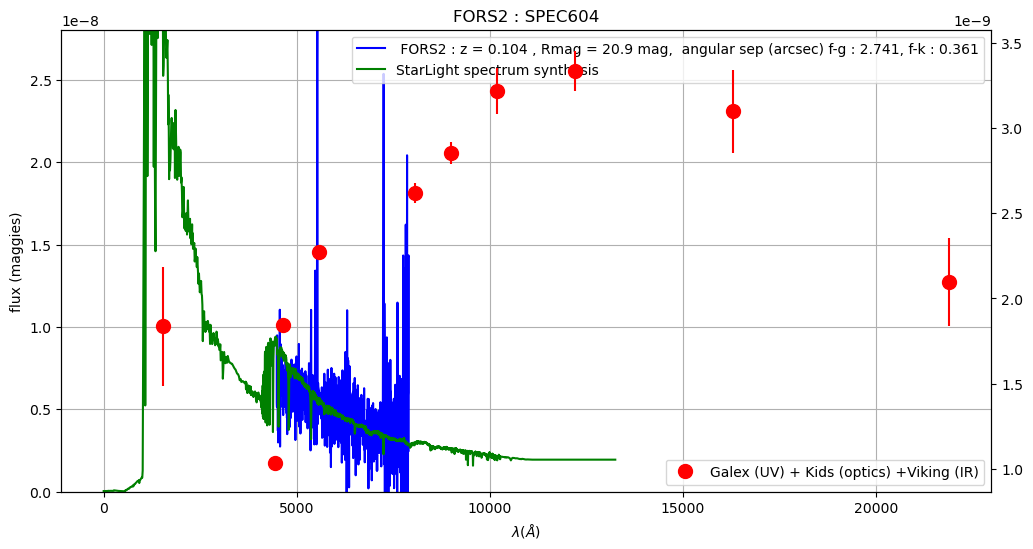

index: 47  ==> SPEC 608
b'weak,[OII],K,H,4000{AA}-break                                               \r'


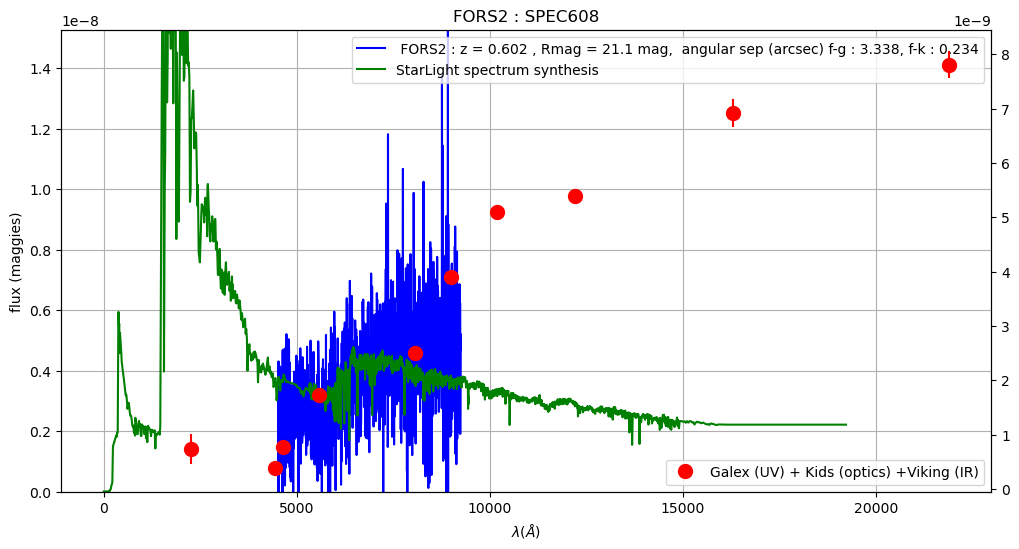

index: 48  ==> SPEC 611
b'[OII],H8,K,H,H{delta}                                                       \r'


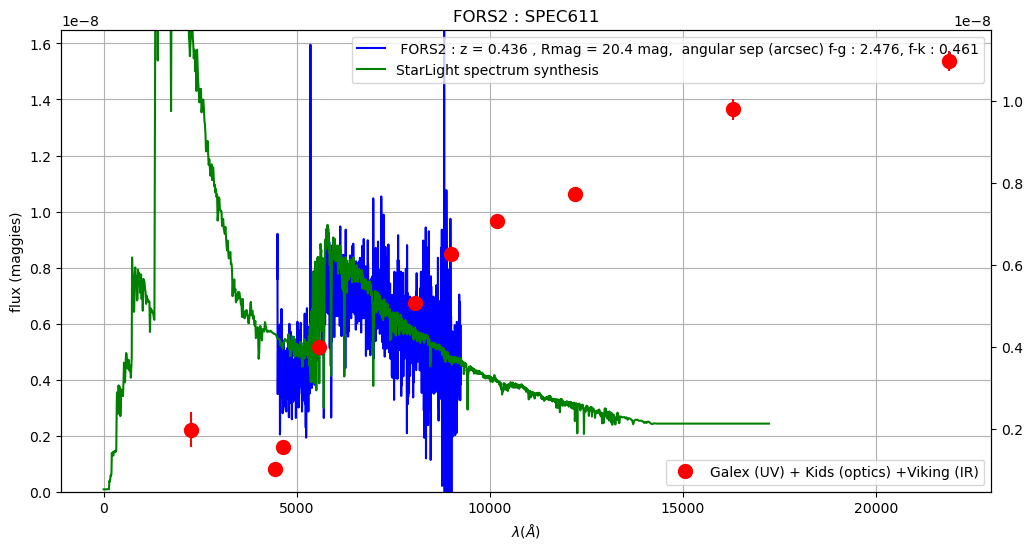

index: 49  ==> SPEC 626
b'[OII],H8,K,H                                                                \r'


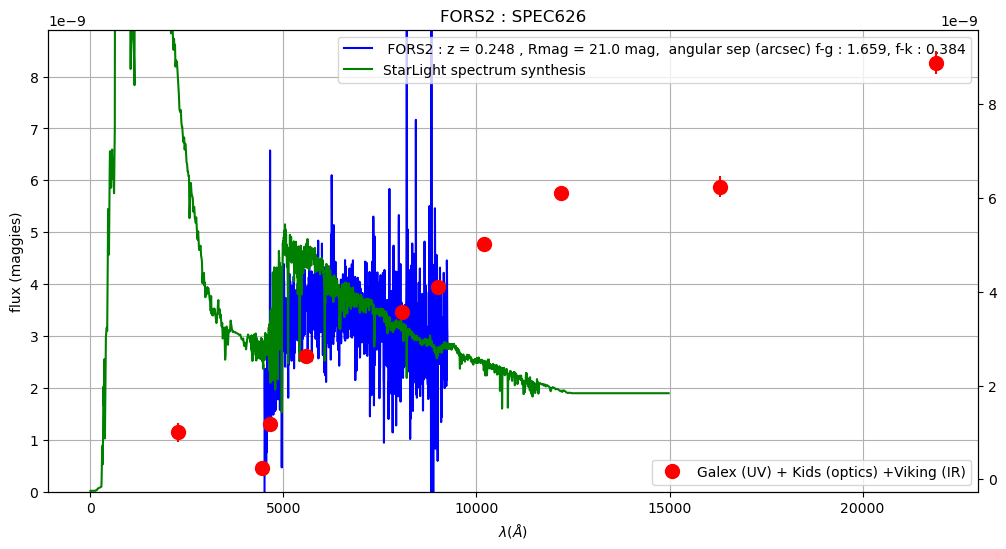

index: 50  ==> SPEC 642
b'[OII],H10,H{gamma},H{beta},[OIII]                                           \r'


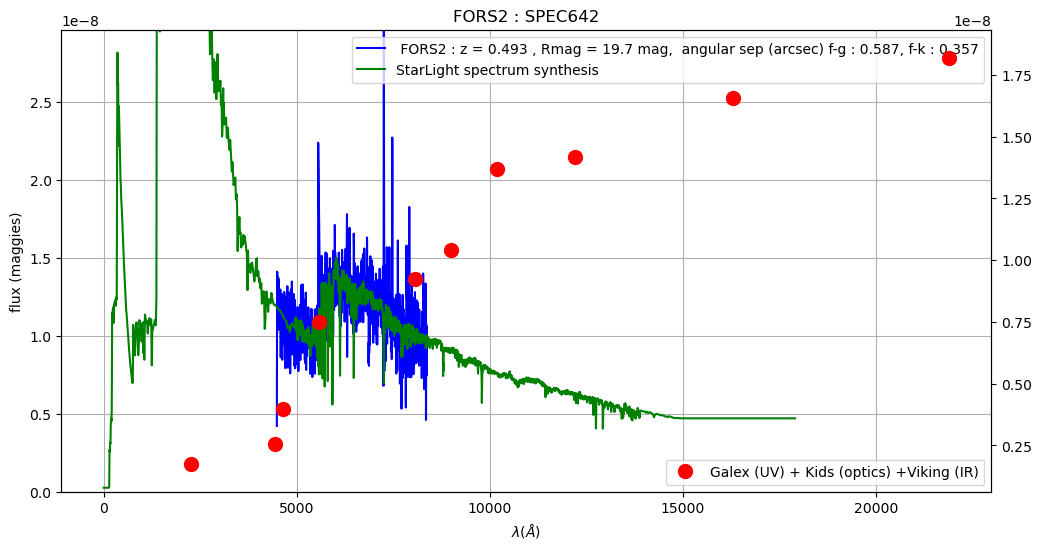

index: 51  ==> SPEC 643
b'H8,K,H,4000{AA}-break                                                       \r'


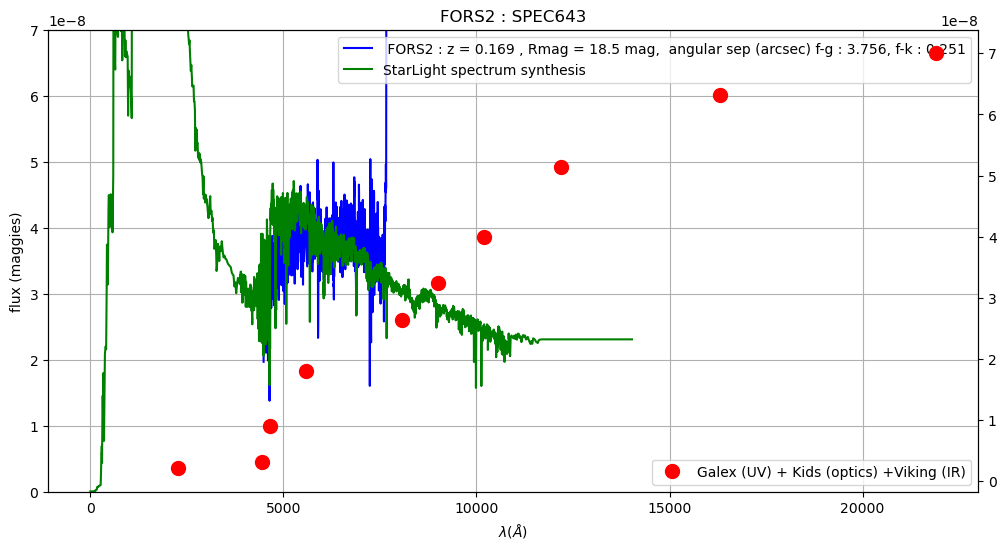

index: 52  ==> SPEC 645
b'H{beta},[OIII],H{alpha}                                                     \r'


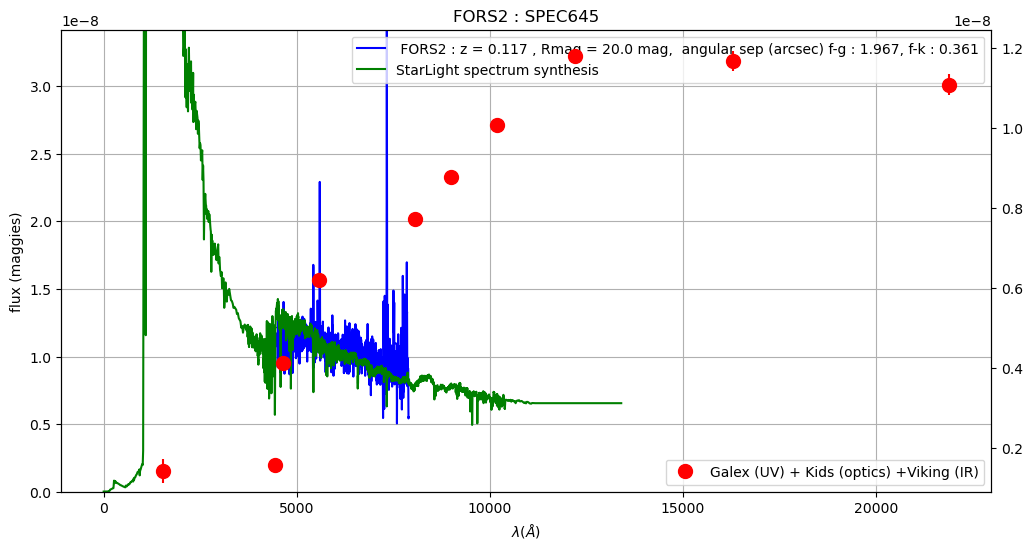

index: 53  ==> SPEC 647
b'H{beta},[OIII],H{alpha}                                                     \r'


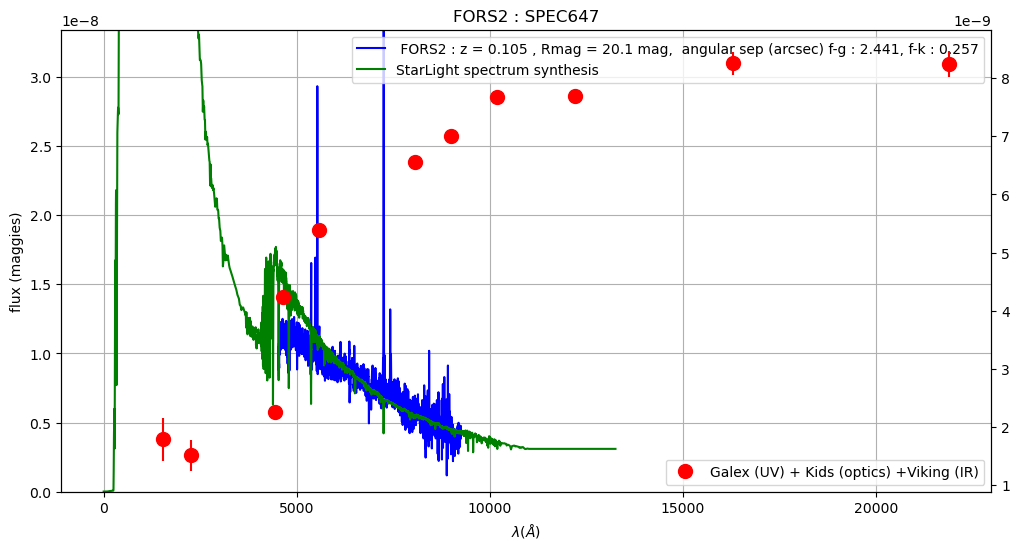

index: 54  ==> SPEC 653
b'[OII],H9,H8,K,H,H{beta},H{alpha}                                            \r'


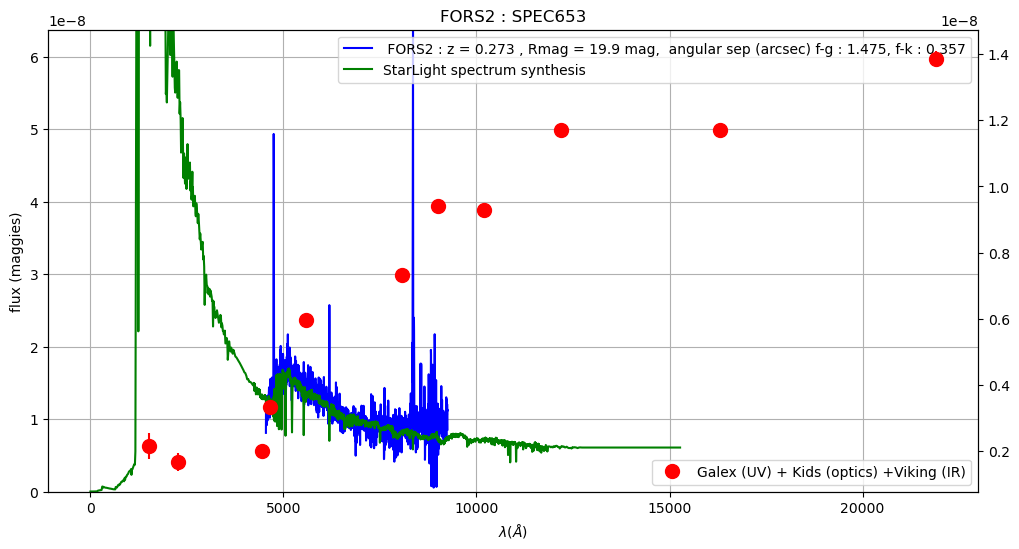

index: 55  ==> SPEC 657
b'H{beta},[OIII],H{alpha}                                                     \r'


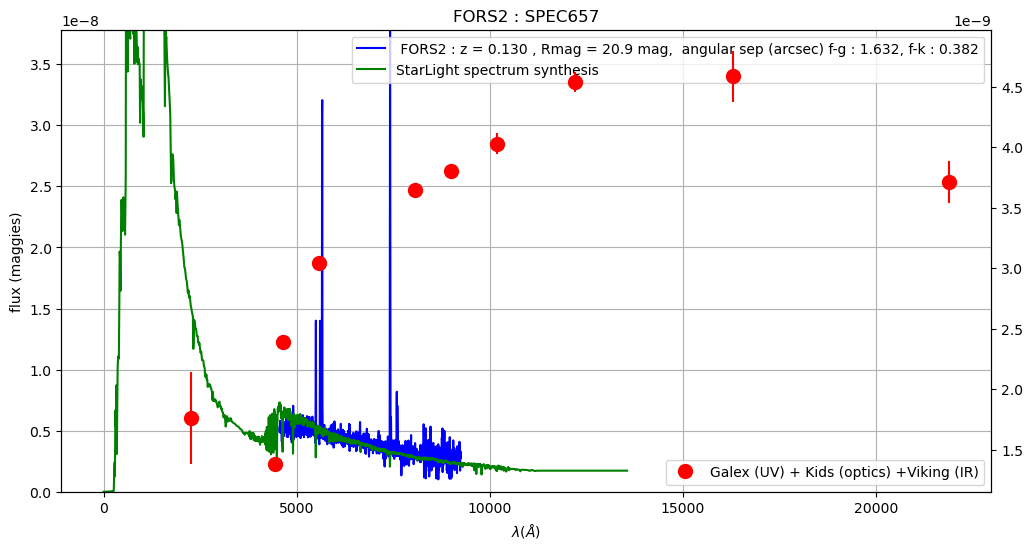

index: 56  ==> SPEC 664
b'[OII],H8,K,H,H{delta},H{beta},[OIII]                                        \r'


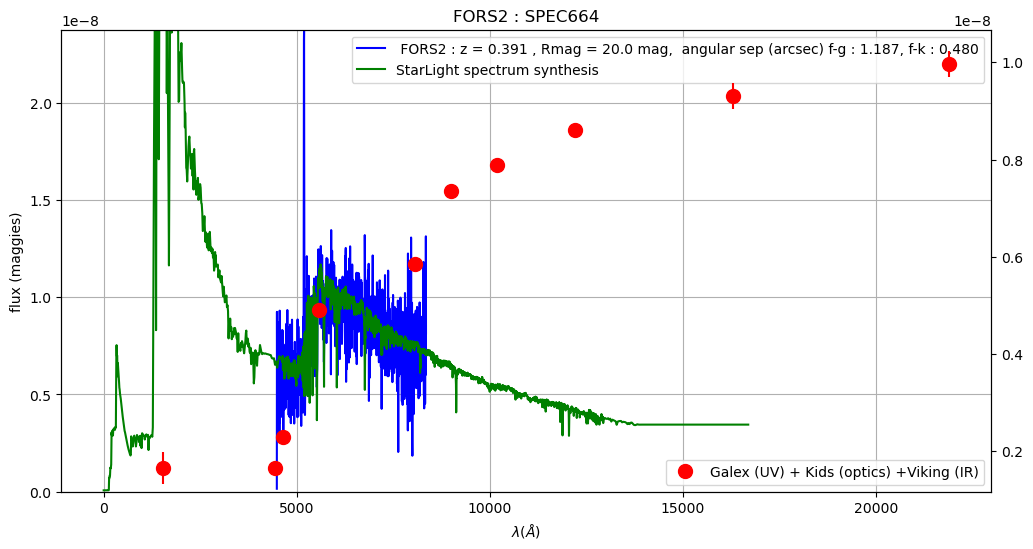

index: 57  ==> SPEC 669
b'[OII],H9,H8,K,H,H{delta}                                                    \r'


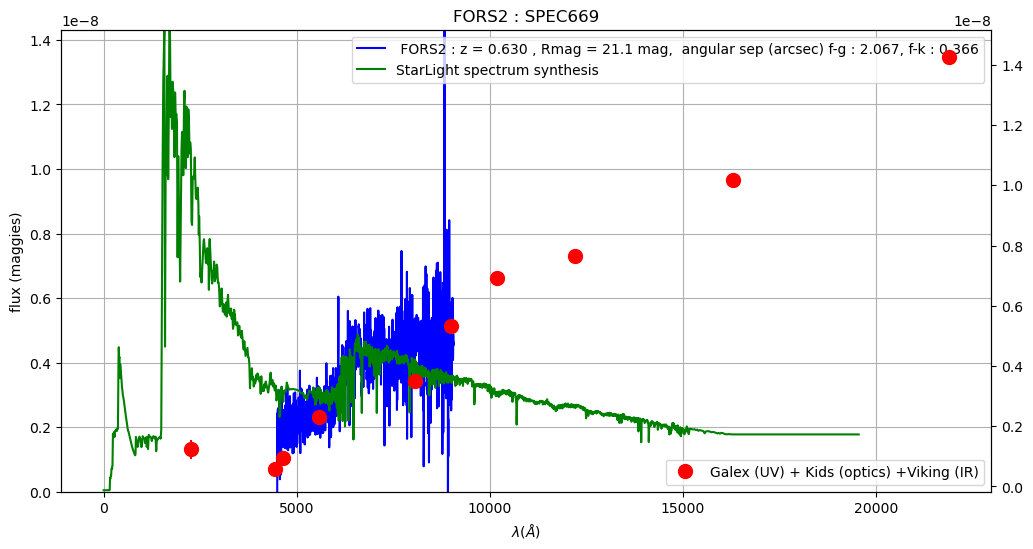

index: 58  ==> SPEC 691
b'[OIII],H{alpha}                                                             \r'


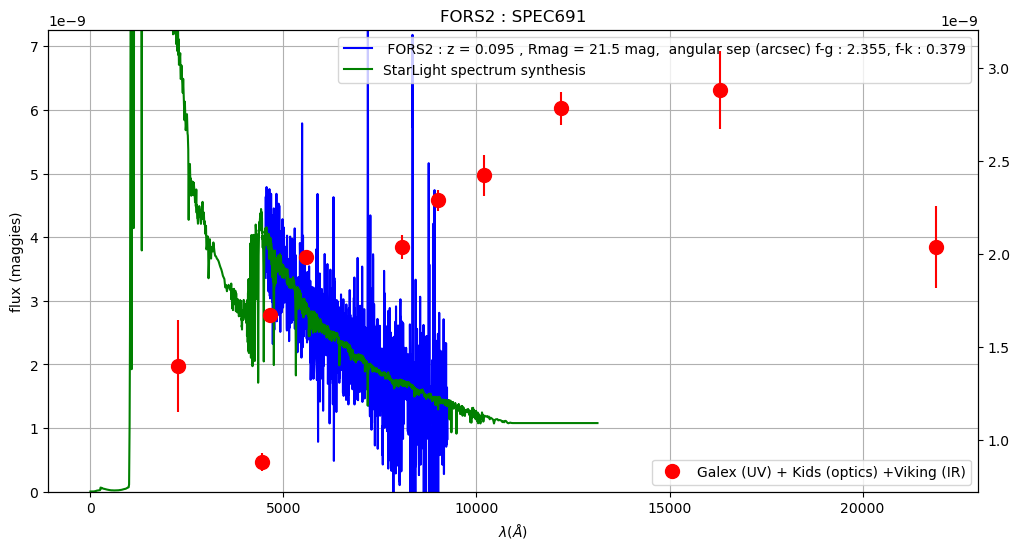

index: 59  ==> SPEC 698
b'H{beta},[OIII],H{alpha}                                                     \r'


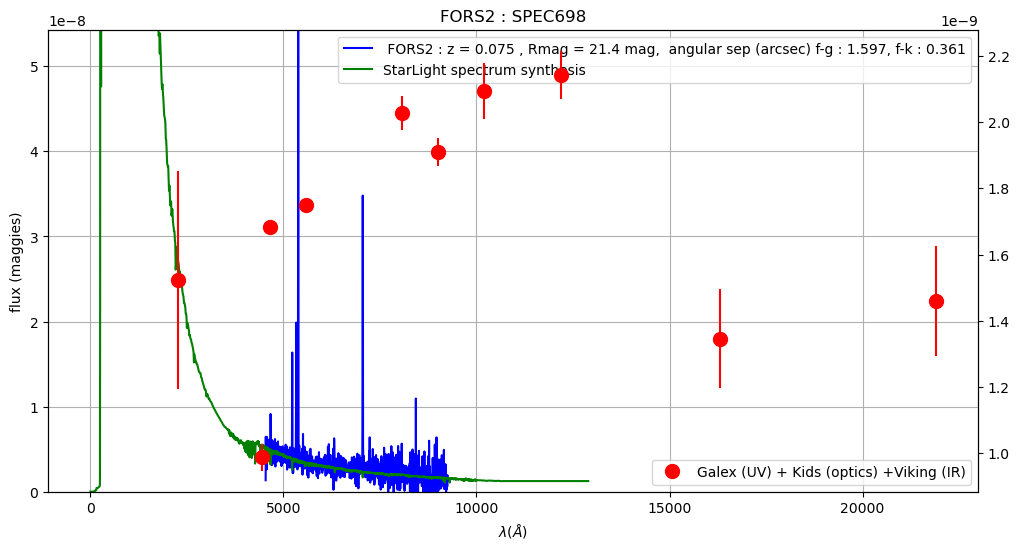

index: 60  ==> SPEC 699
b'H9,H8,K,H,H{delta},H{beta}                                                  \r'


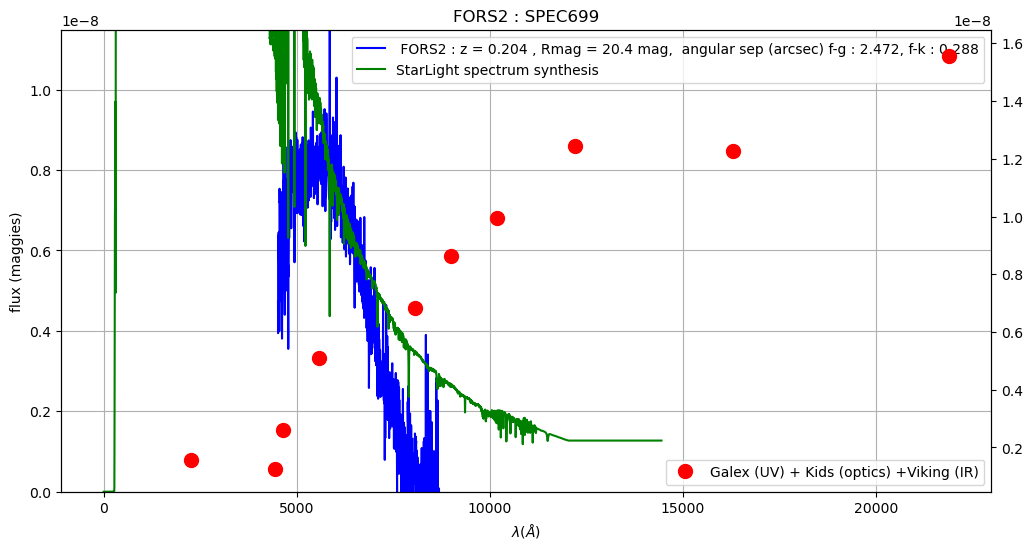

index: 61  ==> SPEC 717
b'[OII]                                                                       \r'


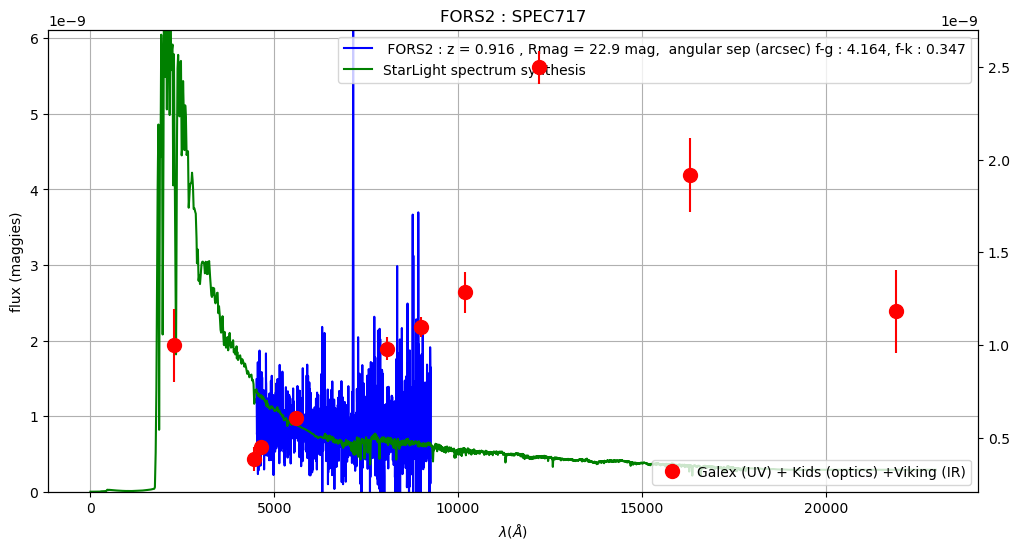

index: 62  ==> SPEC 719
b'[OII],H11,H10,H9,H8,K,H,H{delta},H{beta},[OIII],H{alpha}                    \r'


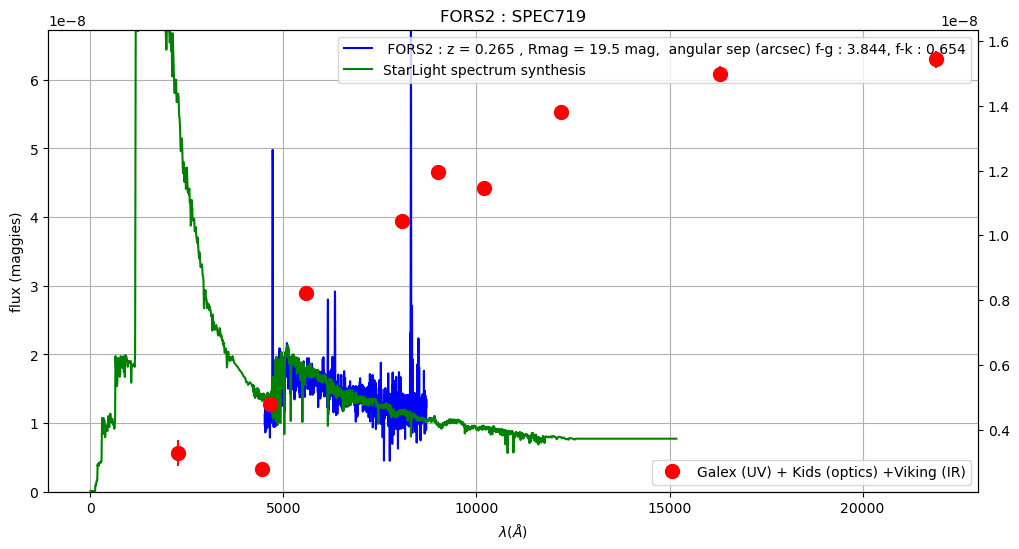

index: 63  ==> SPEC 722
b'broad,MgII,(QSO)                                                            \r'


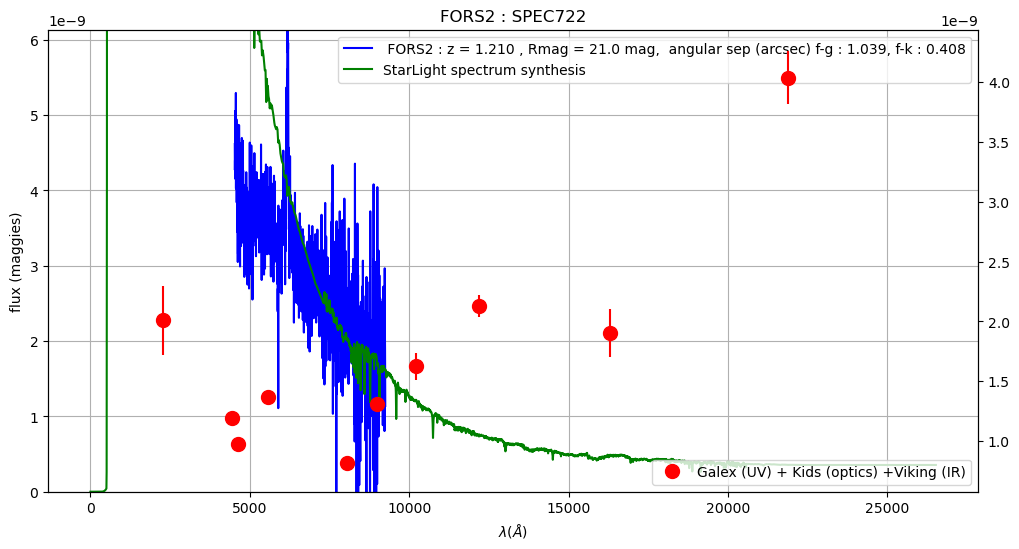

index: 64  ==> SPEC 724
b'[OII],H8,H,H{beta},[OIII],H{alpha}                                          \r'


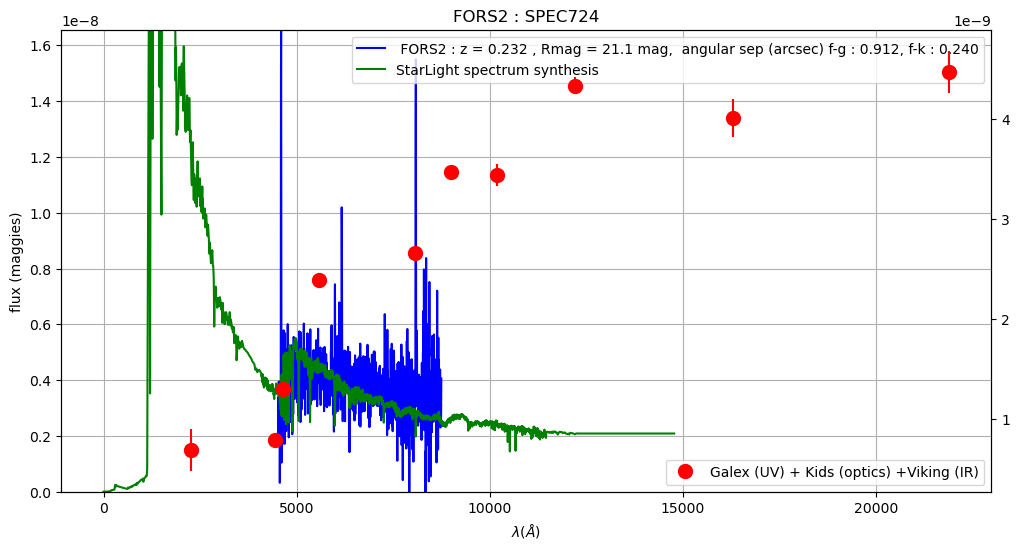

index: 65  ==> SPEC 725
b'[OII],H{beta},[OIII],H{alpha}                                               \r'


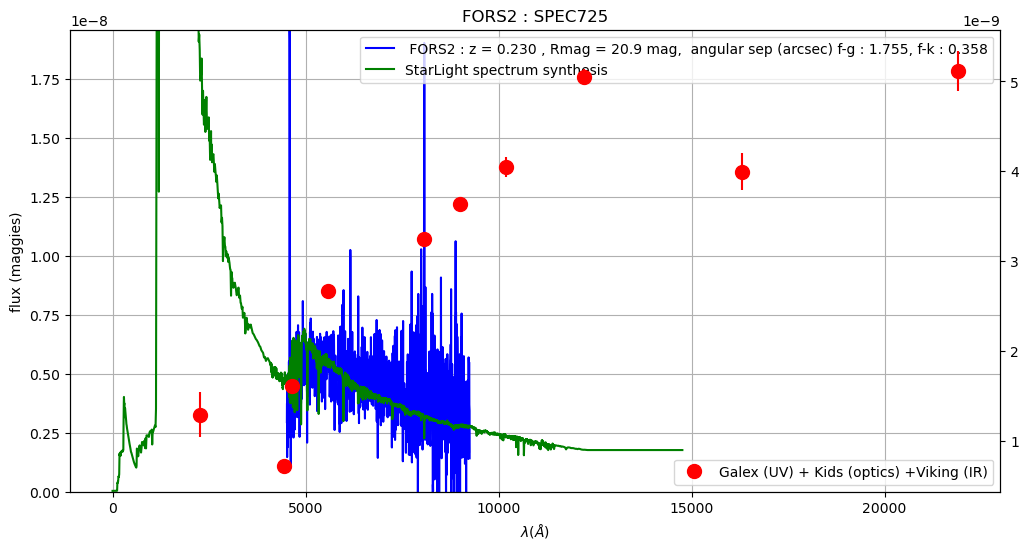

index: 66  ==> SPEC 727
b'[OII],[OIII],H{alpha}                                                       \r'


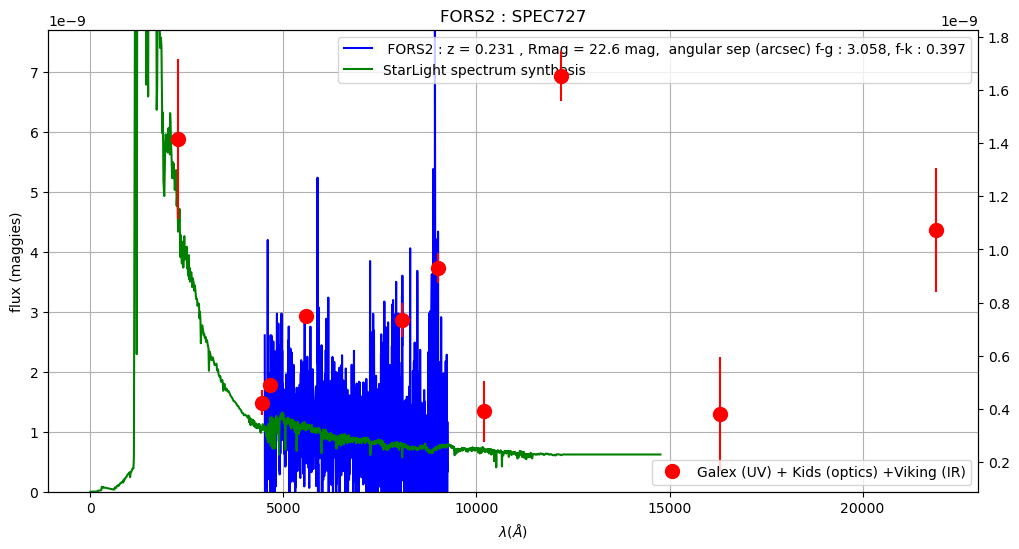

index: 67  ==> SPEC 732
b'H,K,H{gamma},H{beta},[OIII],H{alpha},NII                                    \r'


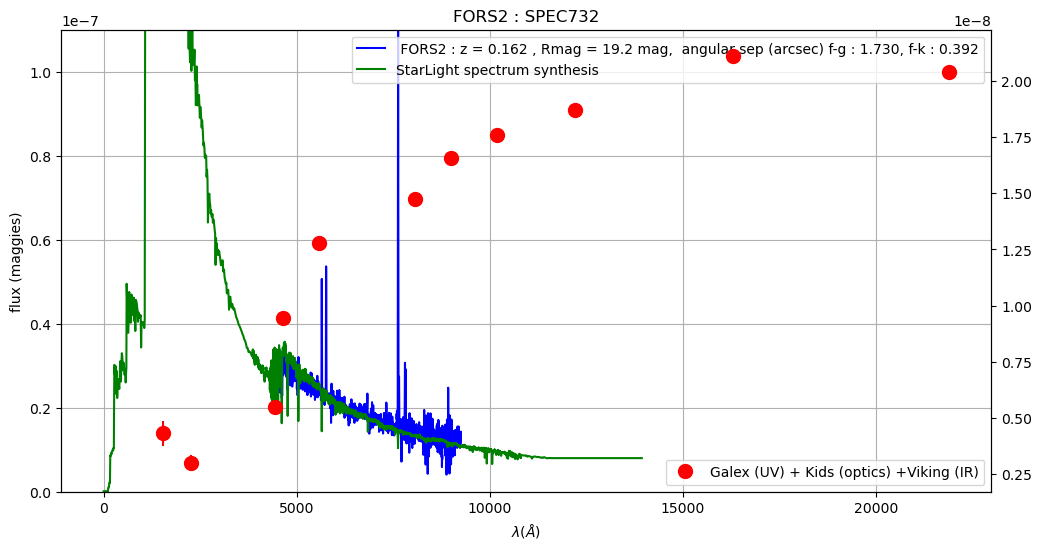

In [49]:
# loop on rows

for idx,row in df.iterrows():
    print("index:",idx," ==> SPEC",row["num"])

    
    idx0 = row["index0"] # index for the spectrum
    
    # compute fluxes in photometry
    mags = [ row["fuv_mag"], row["nuv_mag"], row['MAG_GAAP_u'], row['MAG_GAAP_g'], row['MAG_GAAP_r'], row['MAG_GAAP_i'], row['MAG_GAAP_Z'], row['MAG_GAAP_Y'], 
            row['MAG_GAAP_J'], row['MAG_GAAP_H'],row['MAG_GAAP_Ks'] ]
    
    magserr = [ row["fuv_magerr"], row["nuv_magerr"], row['MAGERR_GAAP_u'], row['MAGERR_GAAP_g'], row['MAGERR_GAAP_r'], row['MAGERR_GAAP_i'], row['MAGERR_GAAP_Z'], row['MAGERR_GAAP_Y'], 
            row['MAGERR_GAAP_J'], row['MAGERR_GAAP_H'],row['MAGERR_GAAP_Ks'] ]
    
    mfluxes = [ 10**(-0.4*m) for m in mags ]
    mfluxeserr = []
    
    for f,em in zip(mfluxes,magserr):
        ferr = 0.4*np.log10(10)*em*f
        mfluxeserr.append(ferr)
        
    
    
    fluxes =  [ row["fuv_flux"], row["nuv_flux"], row['FLUX_GAAP_u'], row['FLUX_GAAP_g'], row['FLUX_GAAP_r'], row['FLUX_GAAP_i'], row['FLUX_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUX_GAAP_J'], row['FLUX_GAAP_H'],row['FLUX_GAAP_Ks'] ]
    
    fluxeserr =  [ row["fuv_fluxerr"], row["nuv_fluxerr"], row['FLUXERR_GAAP_u'], row['FLUXERR_GAAP_g'], row['FLUXERR_GAAP_r'], row['FLUXERR_GAAP_i'], row['FLUXERR_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUXERR_GAAP_J'], row['FLUXERR_GAAP_H'],row['FLUXERR_GAAP_Ks'] ]
    
    
    fig = plt.figure(figsize=(12,6))
    ax=fig.add_subplot(1,1,1)
    
    z = row["redshift"]
    asep_fg = row['asep_galex']
    asep_fk = row['asep_kids']
    rmag = row["Rmag"]
    
    print(row["lines"])
    
    the_label = f" FORS2 : z = {z:.3f} , Rmag = {rmag:.1f} mag,  angular sep (arcsec) f-g : {asep_fg:.3f}, f-k : {asep_fk:.3f}" 
    
    ## Plot Fors2 spectra
    ax.plot(all_df[idx0]["wl"], all_df[idx0]["fl"],'b-',label=the_label)
    #ax.plot(all_df[idx]["wl"], all_df[idx]["fl"],'b-',label=row["num"])
    
    # plt SL in observation frame
    ax.plot(wavelengths_sl_z[idx0,:],spectra_sl_z_norm[idx0,:],c="g",label="StarLight spectrum synthesis") 
    
    # Plot Photometry
    ax2 = ax.twinx()
    ax2.errorbar(WL,mfluxes,yerr=mfluxeserr,fmt='o',color="r",ecolor="r",ms=10,label='Galex (UV) + Kids (optics) +Viking (IR)')
    #ax2.errorbar(WL, fluxes, yerr=fluxes, xerr=None, fmt='o', color="g",ecolor="g")
    ax2.legend(loc="lower right")
    
    
    ax.set_xlabel("$\lambda  (\AA)$ ")
    title = f"FORS2 : {key_tags[idx0]}"
    ax.set_title(title)
    ax.set_ylabel("flux (maggies)")
    ax.legend(loc="upper right")
    ax.grid()
    
    the_max = np.max(all_df[idx0]["fl"])
    
    ax.set_ylim(0,the_max)
    
    plt.show()